In [ ]:
Проаналізуємо за допомогою методів кластерного аналізу товари

In [1]:
%matplotlib inline
from Visualization import give_data
from pandas.plotting import scatter_matrix
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import *
import numpy as np
import matplotlib.pyplot as plt
from Elasticity import elasticity_ols_models
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn import preprocessing
sns.set()

In [2]:
# виберемо параметри для кластеризації
data = give_data(['Source', 'Month', 'Brand', 'Model', 'ENERGY LABEL EU', 'NOFROST SYSTEM','NET LTRS.', 'Sales Units', 'PRICE USD/UN.'])

In [3]:
# редагування
data = data[data['Source'] == 'Traditional Sales']
data = data[(data['ENERGY LABEL EU'] != 'UNKNOWN') & (data['NET LTRS.'] != 'unknown') & (data['NOFROST SYSTEM'] != 'UNKNOWN')]
mas_for_energy = {'B':1, 'A':2, 'A+':3, 'A++':4, 'A+++':5}
mas_for_system = {'YES':1, 'NO':0}
data['ENERGY LABEL EU'] = data['ENERGY LABEL EU'].apply(lambda x: mas_for_energy[x])
data['NOFROST SYSTEM'] = data['NOFROST SYSTEM'].apply(lambda x: mas_for_system[x])
data['NET LTRS.'] = data['NET LTRS.'].apply(lambda x: int(x))

In [4]:
q_mean = {}
p_mean = {}
for i in data['Model'].unique():
    m = data[data['Model'] == i].mean()
    q_mean[i] = m['Quantity']
    p_mean[i] = m['PriceUSD']

In [5]:
el = elasticity_ols_models(data, data['Model'].unique(), correct_length_of_sales=9)

In [6]:
data = data[data['Model'].isin(el['Model'].unique())]# додавання еластичності
data['Elasticity'] = pd.Series(np.random.randn(len(data['Model'])), index=data.index)
data['Elasticity'] = data.apply(lambda x: el[el['Model'] == x['Model']]['Elasticity'].values[0], axis=1)  

In [7]:
data['Quantity'] = data.apply(lambda x: q_mean[x['Model']], axis=1)

In [8]:
data['PriceUSD'] = data.apply(lambda x: p_mean[x['Model']], axis=1)

In [9]:
d = data['Month'].unique()
data = data[data['Month'].isin([d[0]])]

In [10]:
data.head()

Source      Month      Brand           Model  ENERGY LABEL EU  \
0  Traditional Sales 2018-01-01    INDESIT         TIAA 14                3   
1  Traditional Sales 2018-01-01  WHIRLPOOL    BSNF 9121 OX                3   
2  Traditional Sales 2018-01-01         LG     GA-B429SECZ                4   
3  Traditional Sales 2018-01-01    SAMSUNG  RB37J5000SA/UA                3   
4  Traditional Sales 2018-01-01    SAMSUNG  RB37J5000EF/UA                3   

   NOFROST SYSTEM  NET LTRS.    Quantity    PriceUSD  Elasticity  
0               0        245  782.666667  231.121140  -11.815988  
1               1        349  382.475000  501.633589   -0.312873  
2               1        302  573.212532  522.033818    2.804369  
3               1        367  857.768597  609.710515   -0.504816  
4               1        367  441.495167  610.165690    0.455472

In [11]:
data.describe()

ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity     PriceUSD  \
count       606.000000      606.000000  606.000000  606.000000   606.000000   
mean          3.211221        0.491749  314.688119   43.492588   491.778679   
std           0.570579        0.500345  101.986242   87.120934   292.839063   
min           1.000000        0.000000    0.000000    1.222222    90.809411   
25%           3.000000        0.000000  276.250000    5.787500   305.150480   
50%           3.000000        0.000000  312.000000   14.193359   421.186026   
75%           4.000000        1.000000  353.000000   43.371903   598.599963   
max           5.000000        1.000000  651.000000  857.768597  1760.766922   

       Elasticity  
count  606.000000  
mean    -0.007172  
std      1.007531  
min    -11.815988  
25%     -0.078226  
50%      0.000939  
75%      0.105433  
max      5.517989

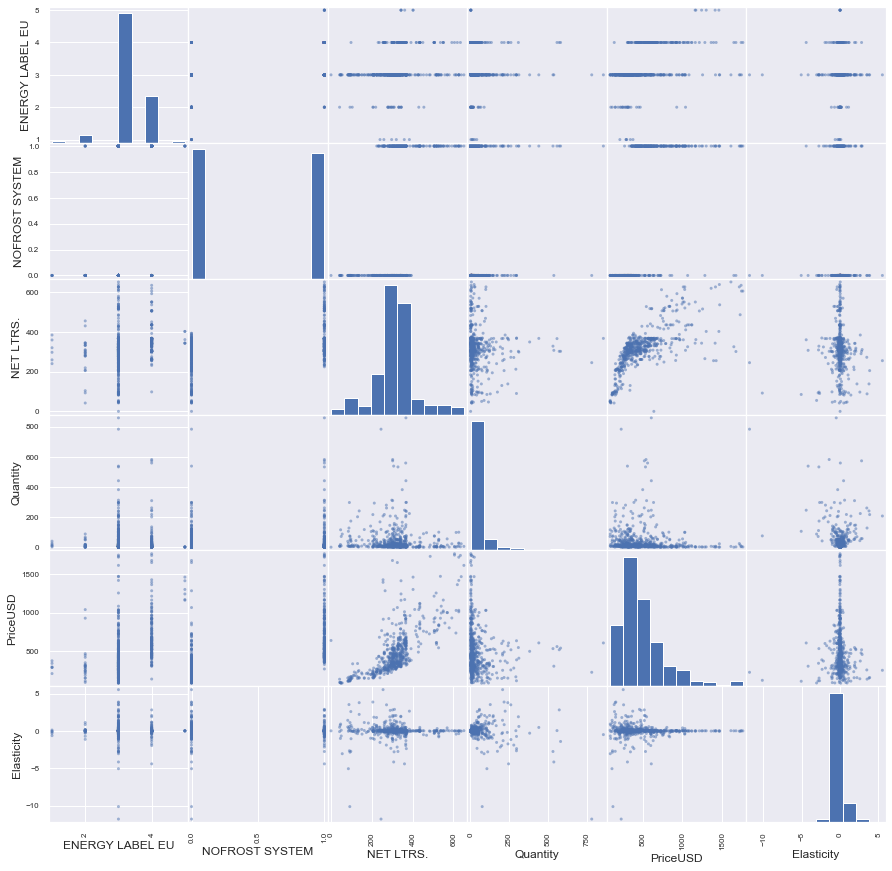

In [12]:
scatter_matrix(data,figsize=(15, 15)); # візуалізація даних

In [13]:
data.corr() # кореляційна матриця

ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000        0.376659   0.220190  0.000147   
NOFROST SYSTEM          0.376659        1.000000   0.511398  0.010288   
NET LTRS.               0.220190        0.511398   1.000000 -0.051696   
Quantity                0.000147        0.010288  -0.051696  1.000000   
PriceUSD                0.449558        0.580978   0.711327 -0.107192   
Elasticity              0.010146        0.011542   0.007683 -0.223126   

                 PriceUSD  Elasticity  
ENERGY LABEL EU  0.449558    0.010146  
NOFROST SYSTEM   0.580978    0.011542  
NET LTRS.        0.711327    0.007683  
Quantity        -0.107192   -0.223126  
PriceUSD         1.000000   -0.002164  
Elasticity      -0.002164    1.000000

In [14]:
data_for_clust=data.drop(data.columns[0], axis=1)
data_for_clust=data_for_clust.drop(data_for_clust.columns[0], axis=1)
data_for_clust=data_for_clust.drop(data_for_clust.columns[0], axis=1)
data_for_clust=data_for_clust.drop(data_for_clust.columns[0], axis=1)
data_for_clust # залишили лише потрібні стовпці

ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.    Quantity    PriceUSD  \
0                  3               0        245  782.666667  231.121140   
1                  3               1        349  382.475000  501.633589   
2                  4               1        302  573.212532  522.033818   
3                  3               1        367  857.768597  609.710515   
4                  3               1        367  441.495167  610.165690   
..               ...             ...        ...         ...         ...   
925                4               0        368    3.600000  690.999488   
931                3               1        256    3.760000  360.944463   
945                3               0        302    2.181818  338.431854   
952                3               1        357    3.691667  508.156044   
975                3               1        324    4.063636  451.300685   

     Elasticity  
0    -11.815988  
1     -0.312873  
2      2.804369  
3     -0.504816  
4      0.455472  
..          ...  
925   -0.008365  
931    0.020116  
945    0.008117  
952    0.018558  
975    0.008372  

[606 rows x 6 columns]

In [15]:
digits_proj = TSNE(random_state=20150101).fit_transform(data_for_clust)# поглянемо на проекцію на площину

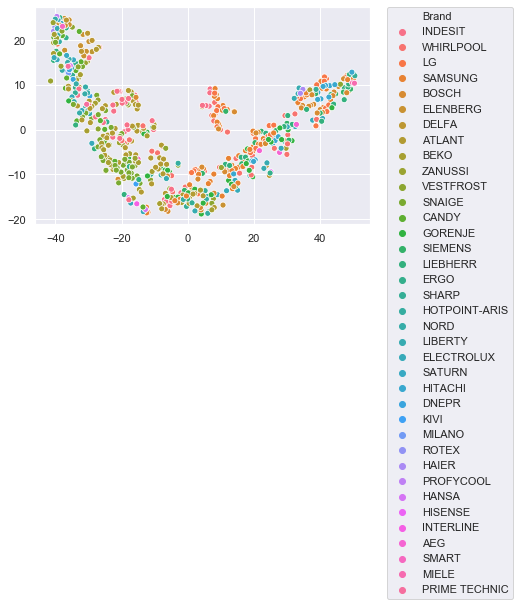

In [16]:
sns.scatterplot(digits_proj[:,0], digits_proj[:,1], hue=data['Brand'], legend='full')# по брендам
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [17]:
dataNorm = preprocessing.scale(data_for_clust) # перетворення даних до нормальних значень

In [18]:
digits_proj_norm = preprocessing.scale(digits_proj)

c:\users\zelen\desktop\python projects\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
c:\users\zelen\desktop\python projects\lib\site-packages\sklearn\preprocessing\_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [19]:
def clustering_criterion_kmeans(data, metric='euclidean'):# збірний критерій силует, калински-харабас и девіс-болдін
    print('Можлива к-ть класів')
    for i in range(2,20):
        m = KMeans(n_clusters=i).fit(data)
        c = silhouette_score(data, m.labels_, metric=metric)
        ch = calinski_harabasz_score(data, m.labels_)
        db = davies_bouldin_score(data, m.labels_)
        if(c>0):
            print('Clusters: ' + str(i) + '\nsilhouette_score: ' + str(c) + '\ncalinski harabasz score: ' + str(ch) + '\ndavies_bouldin_score: ' + str(db))
def clustering_criterion_ierarhi(data, method, metric):
    print('Можлива к-ть класів')
    for i in range(2,20):
        dist = pdist(data, metric)
        link = linkage(dist, method=method)
        cluster=fcluster(link, i, criterion='maxclust')
        c = silhouette_score(data, cluster, metric=metric, sample_size=6000)
        ch = calinski_harabasz_score(data, cluster)
        db = davies_bouldin_score(data, cluster)
        if(c>0):
            print('Clusters: ' + str(i) + '\nsilhouette_score: ' + str(c) + '\ncalinski harabasz score: ' + str(ch) + '\ndavies_bouldin_score: ' + str(db))

In [20]:
clustering_criterion_kmeans(dataNorm)

Можлива к-ть класів
Clusters: 2
silhouette_score: 0.35330813218688734
calinski harabasz score: 256.5022714252987
davies_bouldin_score: 1.2277482579230024
Clusters: 3
silhouette_score: 0.3697287784915536
calinski harabasz score: 216.77422376619296
davies_bouldin_score: 1.103001928217587
Clusters: 4
silhouette_score: 0.340412013189488
calinski harabasz score: 207.41531743300666
davies_bouldin_score: 1.160102066588032
Clusters: 5
silhouette_score: 0.35272617103573817
calinski harabasz score: 195.38576124823135
davies_bouldin_score: 0.9998689167259179
Clusters: 6
silhouette_score: 0.3559794669398179
calinski harabasz score: 190.70699340061407
davies_bouldin_score: 0.9054813725141452
Clusters: 7
silhouette_score: 0.3590004154563582
calinski harabasz score: 191.74941992711857
davies_bouldin_score: 1.0451050035950868
Clusters: 8
silhouette_score: 0.3621020462467752
calinski harabasz score: 183.1163894720823
davies_bouldin_score: 1.0498646267248004
Clusters: 9
silhouette_score: 0.3699104214412

In [21]:
# будуємо кластеризацію методом KMeans
# n_clusters - к-ть кластерів
km = KMeans(n_clusters=9).fit(dataNorm)

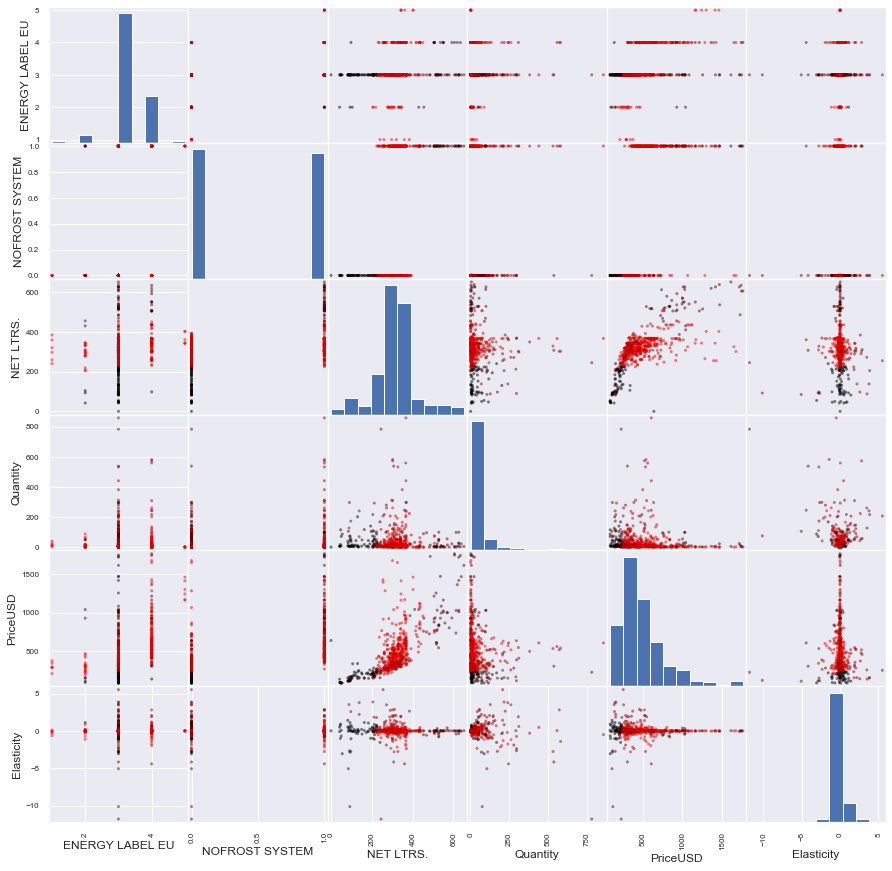

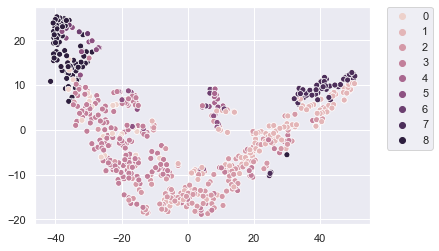

In [22]:
scatter_matrix(data_for_clust, c=km.labels_, cmap='flag', figsize=(15,15))
plt.show()
sns.scatterplot(digits_proj[:,0], digits_proj[:,1], hue=km.labels_, legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [23]:
data['cluster_kmean_nd_9']=km.labels_+1

Кластер 1
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.   Quantity    PriceUSD  \
count        22.000000            22.0   22.000000  22.000000   22.000000   
mean          1.727273             0.0  294.090909  23.042685  280.725479   
std           0.455842             0.0   47.954253  23.986451   55.761390   
min           1.000000             0.0  205.000000   1.608333  155.371510   
25%           1.250000             0.0  278.250000   6.670833  246.207462   
50%           2.000000             0.0  296.000000  14.819444  293.066451   
75%           2.000000             0.0  329.750000  26.429762  316.930430   
max           2.000000             0.0  384.000000  89.102700  379.574051   

       Elasticity  
count   22.000000  
mean    -0.111159  
std      0.384378  
min     -1.138110  
25%     -0.241166  
50%     -0.053336  
75%      0.089179  
max      0.842468  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000           

c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


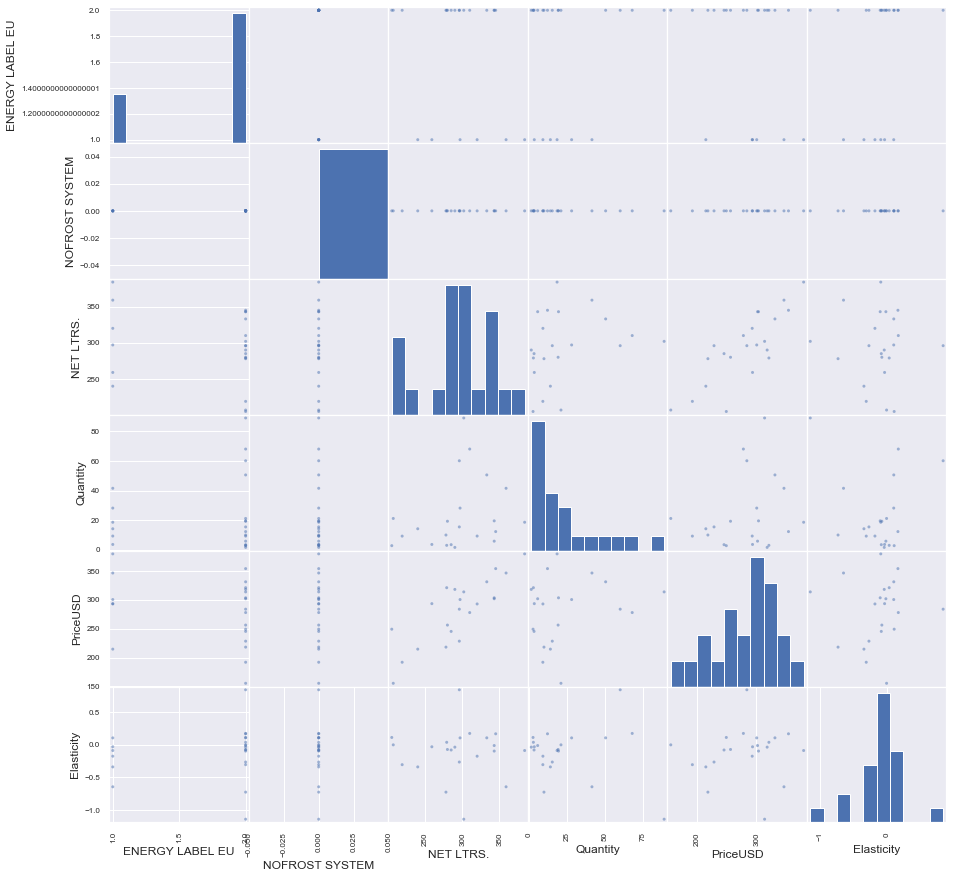

Кластер 2
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity     PriceUSD  \
count       116.000000      116.000000  116.000000  116.000000   116.000000   
mean          4.051724        0.939655  349.172414   28.064687   737.234746   
std           0.222430        0.239158   50.949297   43.316074   273.860527   
min           4.000000        0.000000  237.000000    1.222222   394.313494   
25%           4.000000        1.000000  322.500000    3.985955   565.053539   
50%           4.000000        1.000000  347.500000   13.595871   655.165610   
75%           4.000000        1.000000  366.000000   33.507292   861.182390   
max           5.000000        1.000000  507.000000  261.817042  1673.411397   

       Elasticity  
count  116.000000  
mean    -0.026154  
std      0.383619  
min     -1.967937  
25%     -0.048009  
50%     -0.000446  
75%      0.032535  
max      1.169534  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1

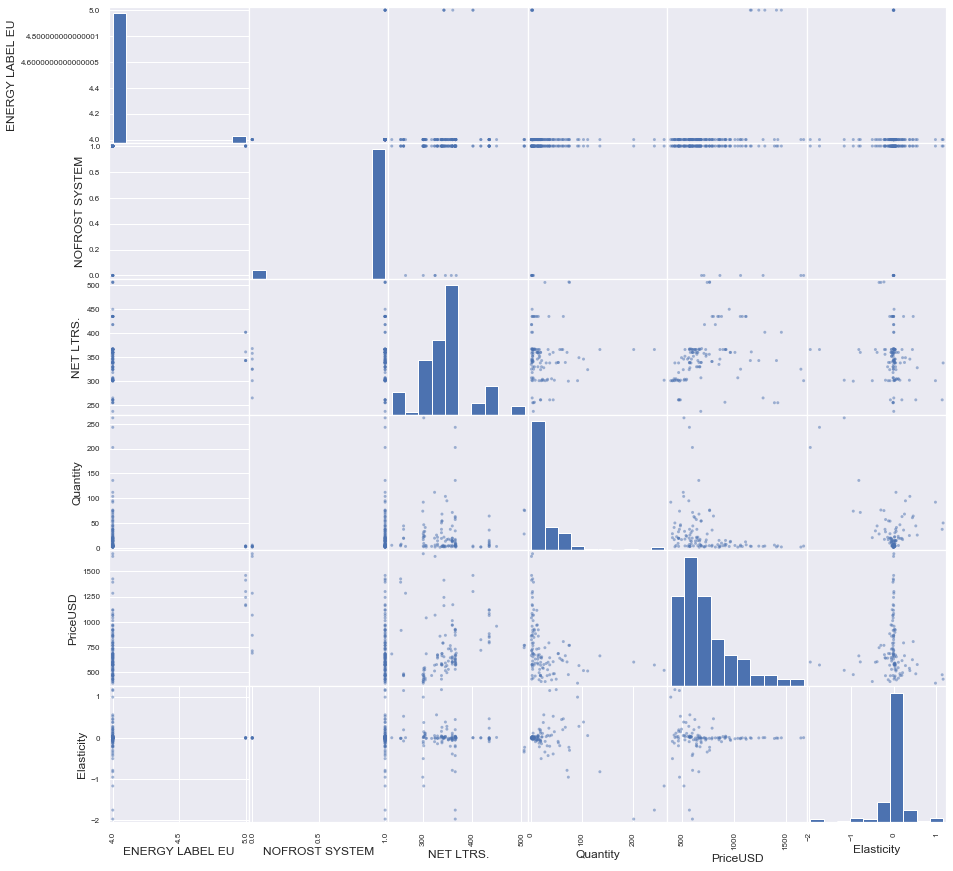

Кластер 3
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count       124.000000           124.0  124.000000  124.000000  124.000000   
mean          2.975806             1.0  323.274194   23.237025  495.039820   
std           0.154273             0.0   40.333234   38.601437  113.557160   
min           2.000000             1.0  224.000000    2.033333  273.862688   
25%           3.000000             1.0  305.750000    5.191714  424.500669   
50%           3.000000             1.0  324.000000    9.782870  461.025034   
75%           3.000000             1.0  340.750000   20.285207  541.910825   
max           3.000000             1.0  440.000000  211.333333  958.849592   

       Elasticity  
count  124.000000  
mean    -0.008005  
std      0.300277  
min     -2.175183  
25%     -0.051842  
50%      0.005199  
75%      0.075157  
max      0.691027  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:81: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:71: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


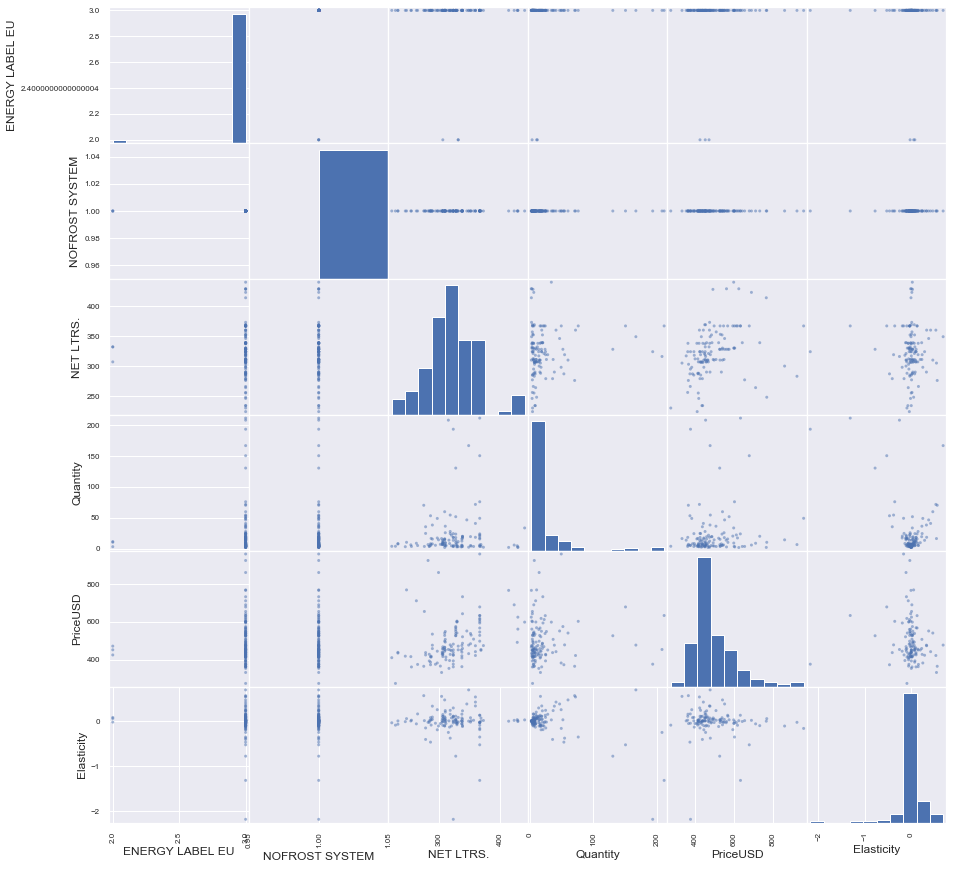

Кластер 4
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count       182.000000           182.0  182.000000  182.000000  182.000000   
mean          3.126374             0.0  307.280220   26.561350  361.512187   
std           0.333187             0.0   36.372285   34.090163  106.115849   
min           3.000000             0.0  231.000000    1.753669  203.463637   
25%           3.000000             0.0  279.000000    6.793445  301.338251   
50%           3.000000             0.0  308.000000   11.629751  337.243988   
75%           3.000000             0.0  336.250000   30.754546  385.817981   
max           4.000000             0.0  393.000000  238.416667  843.391854   

       Elasticity  
count  182.000000  
mean    -0.022956  
std      0.424423  
min     -2.814364  
25%     -0.088148  
50%      0.000213  
75%      0.102136  
max      1.137789  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

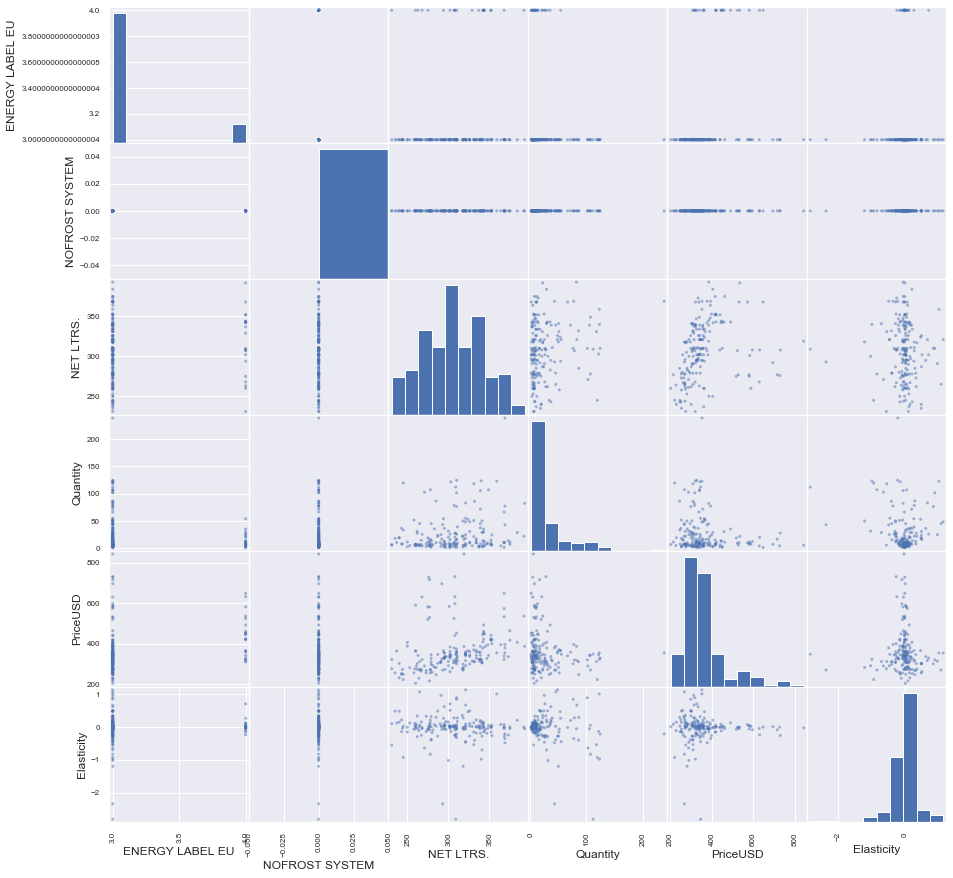

Кластер 5
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count         8.000000             8.0    8.000000    8.000000    8.000000   
mean          3.375000             1.0  343.500000  528.259416  565.549595   
std           0.517549             0.0   28.977824  167.492428   48.551926   
min           3.000000             1.0  302.000000  297.666667  501.633589   
25%           3.000000             1.0  321.500000  426.740125  532.963402   
50%           3.000000             1.0  357.500000  545.802586  553.142020   
75%           4.000000             1.0  367.000000  575.372446  609.824309   
max           4.000000             1.0  367.000000  857.768597  637.962513   

       Elasticity  
count    8.000000  
mean    -0.307976  
std      1.599561  
min     -2.767178  
25%     -0.917368  
50%     -0.408844  
75%      0.138705  
max      2.804369  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

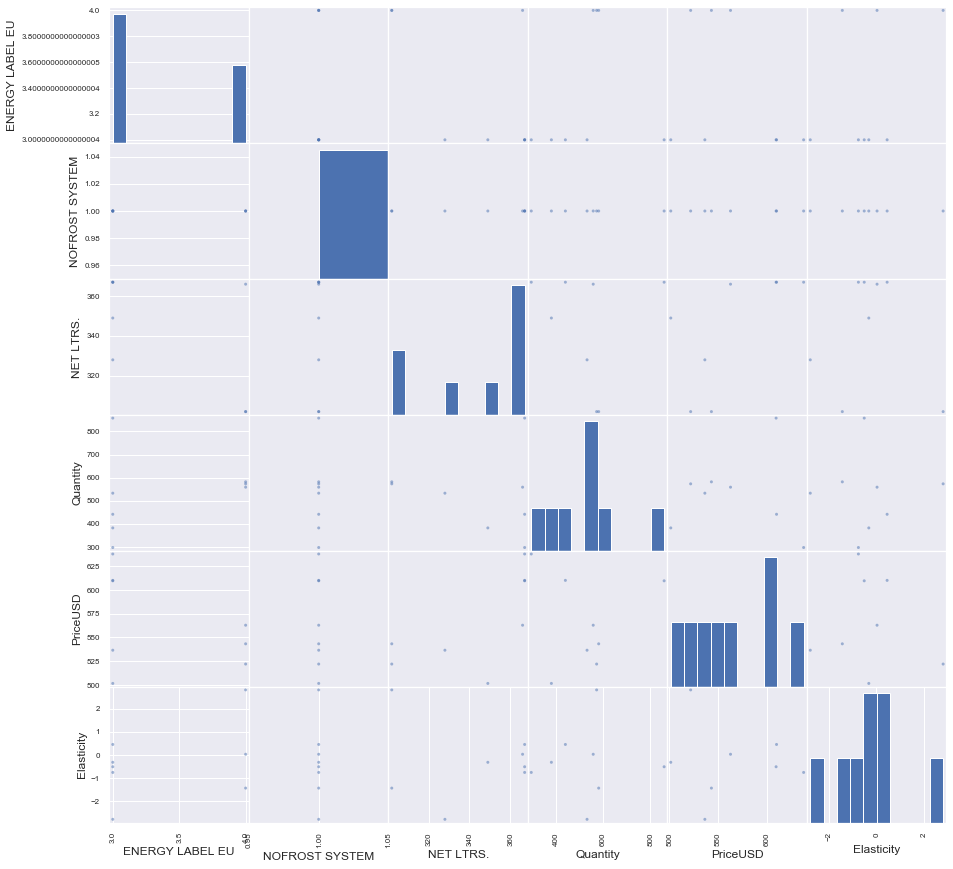

Кластер 6
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count        27.000000       27.000000   27.000000   27.000000   27.000000   
mean          3.111111        0.333333  263.851852  155.296439  331.053430   
std           0.320256        0.480384   76.920390   84.042552  138.050124   
min           3.000000        0.000000   88.000000   44.741667  142.775223   
25%           3.000000        0.000000  217.500000   81.597255  205.759960   
50%           3.000000        0.000000  290.000000  146.416667  306.623104   
75%           3.000000        1.000000  310.500000  217.837238  467.527466   
max           4.000000        1.000000  384.000000  312.916667  550.397043   

       Elasticity  
count   27.000000  
mean     2.159512  
std      1.162405  
min      0.018706  
25%      1.397907  
50%      1.952064  
75%      2.687280  
max      5.517989  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

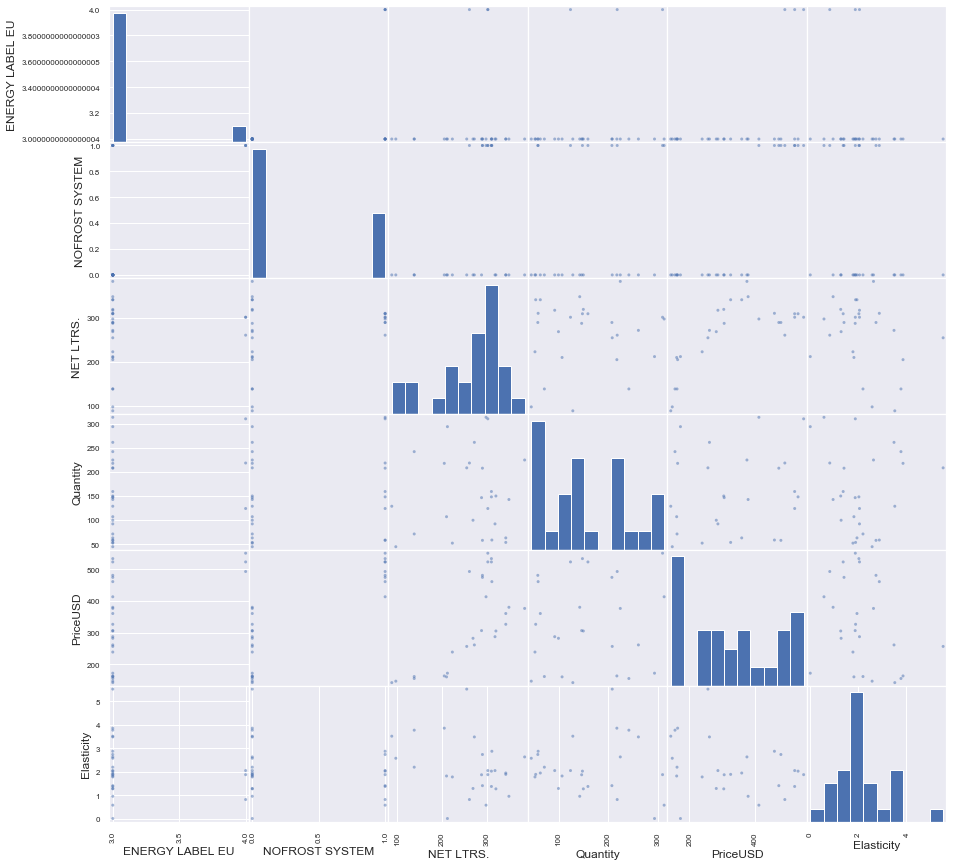

Кластер 7
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count         9.000000        9.000000    9.000000    9.000000    9.000000   
mean          3.111111        0.111111  212.888889  311.253897  260.952195   
std           0.333333        0.333333  121.849748  222.165892  162.652903   
min           3.000000        0.000000   85.000000   76.510583  115.495621   
25%           3.000000        0.000000   92.000000  174.658333  127.483214   
50%           3.000000        0.000000  245.000000  280.166667  231.121140   
75%           3.000000        0.000000  307.000000  298.166667  309.745992   
max           4.000000        1.000000  369.000000  782.666667  609.454150   

       Elasticity  
count    9.000000  
mean    -5.036752  
std      3.551456  
min    -11.815988  
25%     -5.071539  
50%     -4.170003  
75%     -2.670198  
max     -1.906452  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

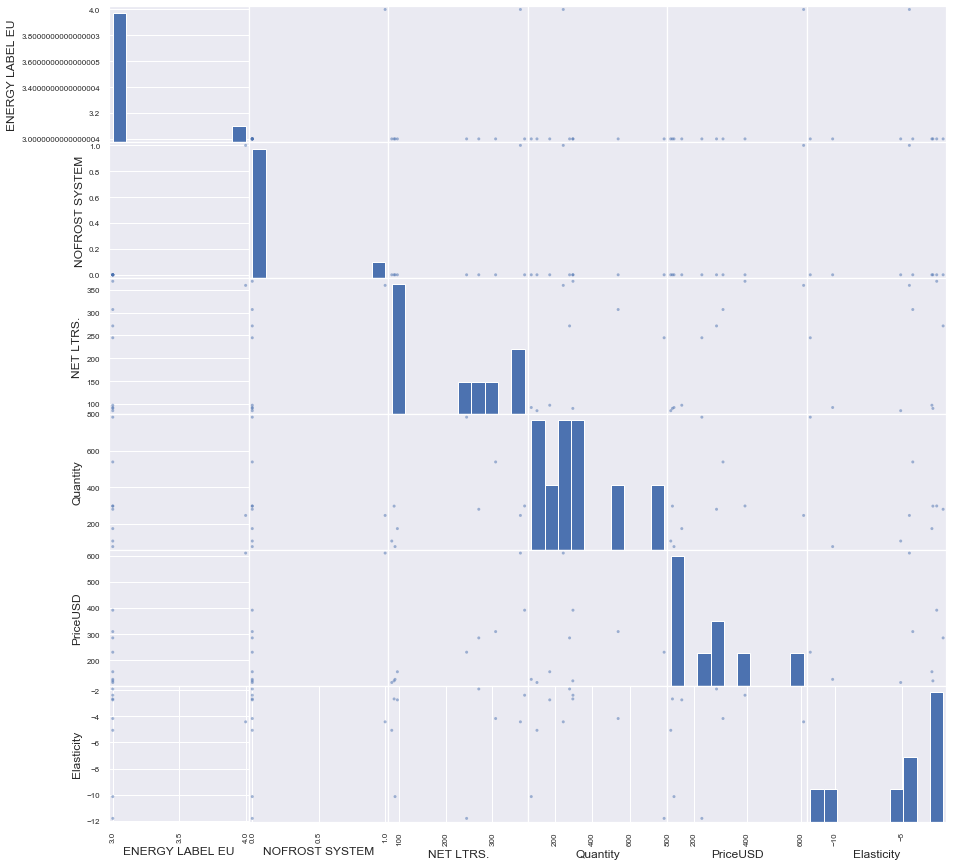

Кластер 8
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity     PriceUSD  \
count        47.000000            47.0   47.000000   47.000000    47.000000   
mean          3.191489             1.0  542.148936   22.312864  1053.275023   
std           0.495120             0.0   62.440573   30.016156   331.632071   
min           2.000000             1.0  387.000000    1.363636   547.148853   
25%           3.000000             1.0  512.500000    3.275568   835.678504   
50%           3.000000             1.0  536.000000    7.610487  1000.519304   
75%           3.000000             1.0  598.500000   25.095833  1188.397006   
max           4.000000             1.0  651.000000  101.110833  1760.766922   

       Elasticity  
count   47.000000  
mean    -0.074560  
std      0.222599  
min     -0.809636  
25%     -0.035101  
50%     -0.011242  
75%      0.007228  
max      0.396754  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1

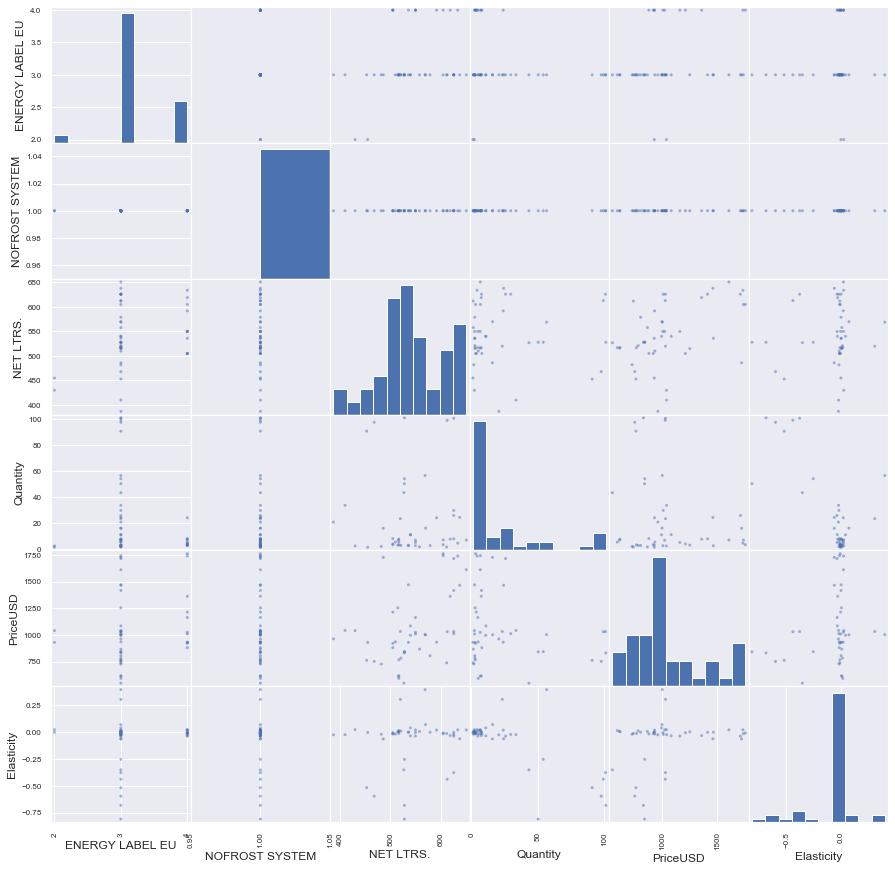

Кластер 9
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count        71.000000            71.0   71.000000   71.000000   71.000000   
mean          2.971831             0.0  147.140845   36.752675  194.749264   
std           0.237356             0.0   64.099319   42.636791   77.745974   
min           2.000000             0.0    0.000000    1.555556   90.809411   
25%           3.000000             0.0   95.000000    8.056917  151.445736   
50%           3.000000             0.0  150.000000   17.055556  191.167860   
75%           3.000000             0.0  207.000000   50.316712  225.252723   
max           4.000000             0.0  240.000000  202.916742  641.617703   

       Elasticity  
count   71.000000  
mean    -0.009918  
std      0.741792  
min     -3.063760  
25%     -0.108731  
50%      0.030050  
75%      0.379139  
max      1.408134  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

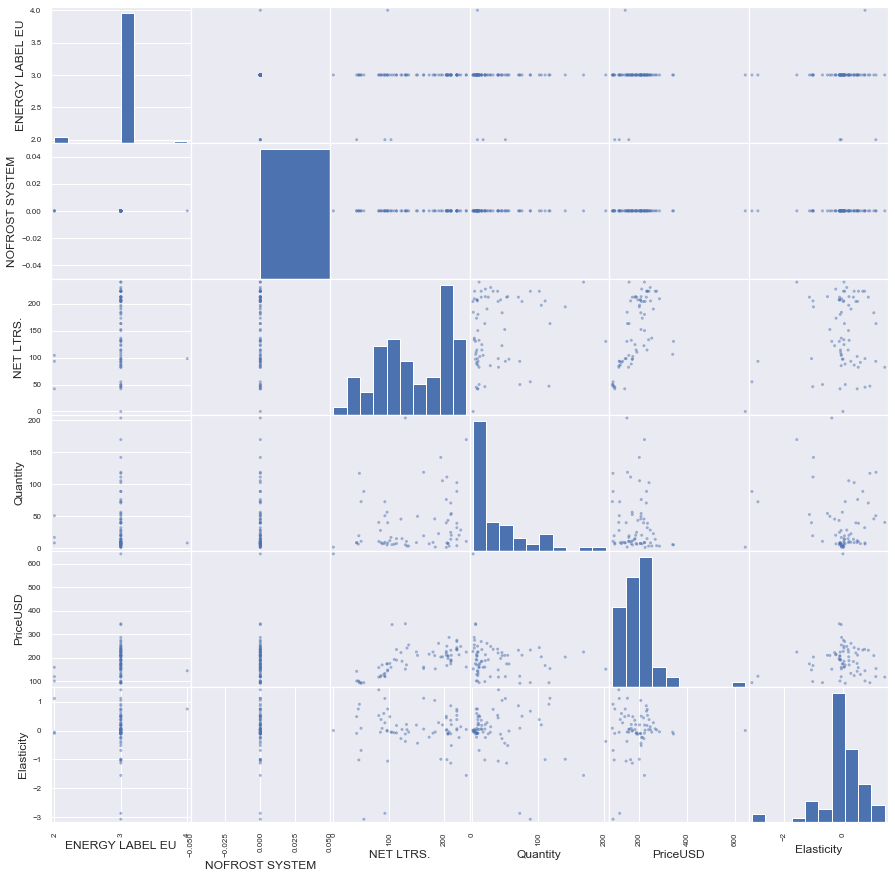

In [25]:
for i in np.unique(km.labels_+1):# виведемо відомості по класам
    print('Кластер ' + str(i))
    print(data[data['cluster_kmean_nd_9']==i][['ENERGY LABEL EU', 'NOFROST SYSTEM', 'NET LTRS.', 'Quantity', 'PriceUSD', 'Elasticity']].describe())
    print(data[data['cluster_kmean_nd_9']==i][['ENERGY LABEL EU', 'NOFROST SYSTEM', 'NET LTRS.', 'Quantity', 'PriceUSD', 'Elasticity']].corr())
    scatter_matrix(data[data['cluster_kmean_nd_9']==i][['ENERGY LABEL EU', 'NOFROST SYSTEM', 'NET LTRS.', 'Quantity', 'PriceUSD', 'Elasticity']], cmap='flag', figsize=(15,15)) 
    plt.show()

In [ ]:
Побудуємо кластеризацію на отриманих даних T-SNE

In [26]:
clustering_criterion_kmeans(digits_proj_norm)

Можлива к-ть класів
Clusters: 2
silhouette_score: 0.4420161
calinski harabasz score: 512.5762265738252
davies_bouldin_score: 0.8518050737651865
Clusters: 3
silhouette_score: 0.5176979
calinski harabasz score: 908.8674944661243
davies_bouldin_score: 0.6724969059763822
Clusters: 4
silhouette_score: 0.4941217
calinski harabasz score: 980.5007329769227
davies_bouldin_score: 0.6495978036338907
Clusters: 5
silhouette_score: 0.4915681
calinski harabasz score: 1098.785513946958
davies_bouldin_score: 0.6789871188048516
Clusters: 6
silhouette_score: 0.477158
calinski harabasz score: 1180.8626614562609
davies_bouldin_score: 0.6756604334190878
Clusters: 7
silhouette_score: 0.50146735
calinski harabasz score: 1258.1837382892018
davies_bouldin_score: 0.6254119641530274
Clusters: 8
silhouette_score: 0.49033374
calinski harabasz score: 1305.0802357942557
davies_bouldin_score: 0.6271225090429366
Clusters: 9
silhouette_score: 0.48775998
calinski harabasz score: 1385.6905687642793
davies_bouldin_score: 0

In [27]:
# будуємо кластеризацію методом KMeans
# n_clusters - к-ть кластерів
km = KMeans(n_clusters=8).fit(digits_proj_norm)

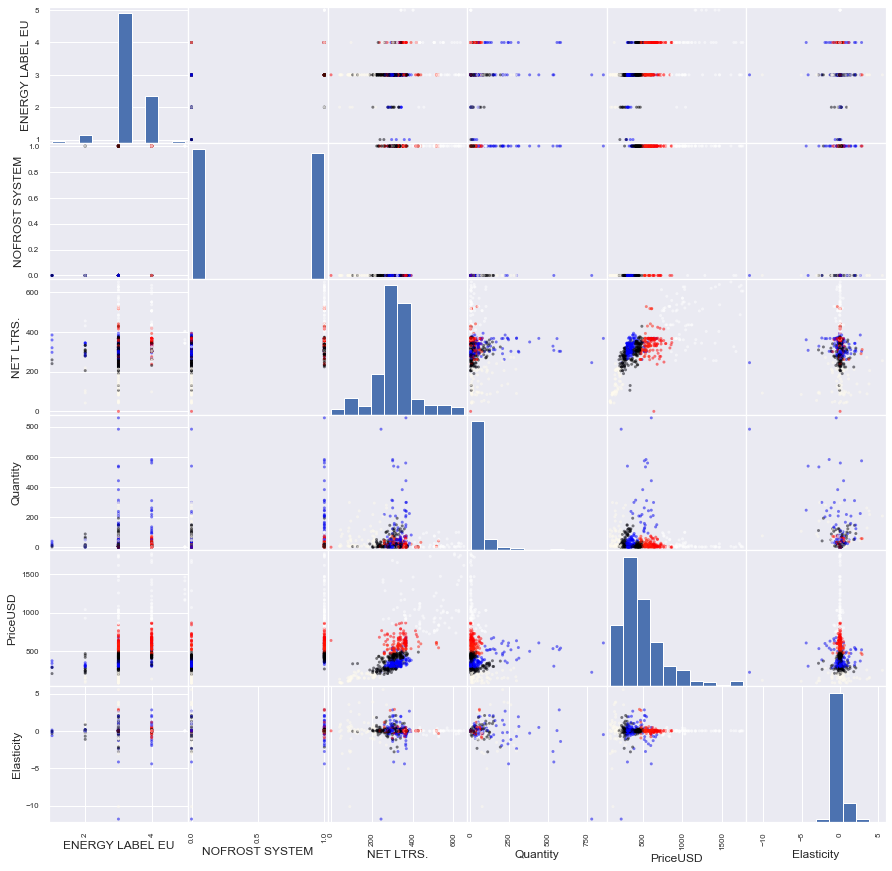

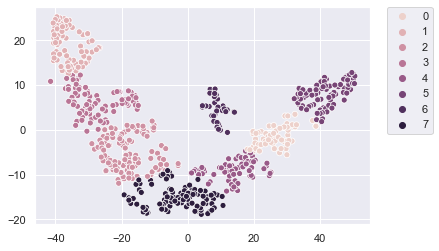

In [28]:
scatter_matrix(data_for_clust, c=km.labels_, cmap='flag', figsize=(15,15))
plt.show()
sns.scatterplot(digits_proj[:,0], digits_proj[:,1], hue=km.labels_, legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [29]:
data['cluster_kmean_t_sne']=km.labels_+1

Кластер 1
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.   Quantity    PriceUSD  \
count        61.000000       61.000000   61.000000  61.000000   61.000000   
mean          3.672131        0.786885  337.950820  18.191971  679.811201   
std           0.473333        0.412907   57.675941  20.073702   71.635834   
min           3.000000        0.000000    0.000000   1.222222  572.970886   
25%           3.000000        1.000000  330.000000   4.013636  631.395363   
50%           4.000000        1.000000  356.000000  10.083333  665.709958   
75%           4.000000        1.000000  366.000000  21.333333  718.980419   
max           4.000000        1.000000  423.000000  76.018924  867.867151   

       Elasticity  
count   61.000000  
mean    -0.047766  
std      0.166343  
min     -0.786454  
25%     -0.083901  
50%     -0.008365  
75%      0.003333  
max      0.444387  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000        0.3

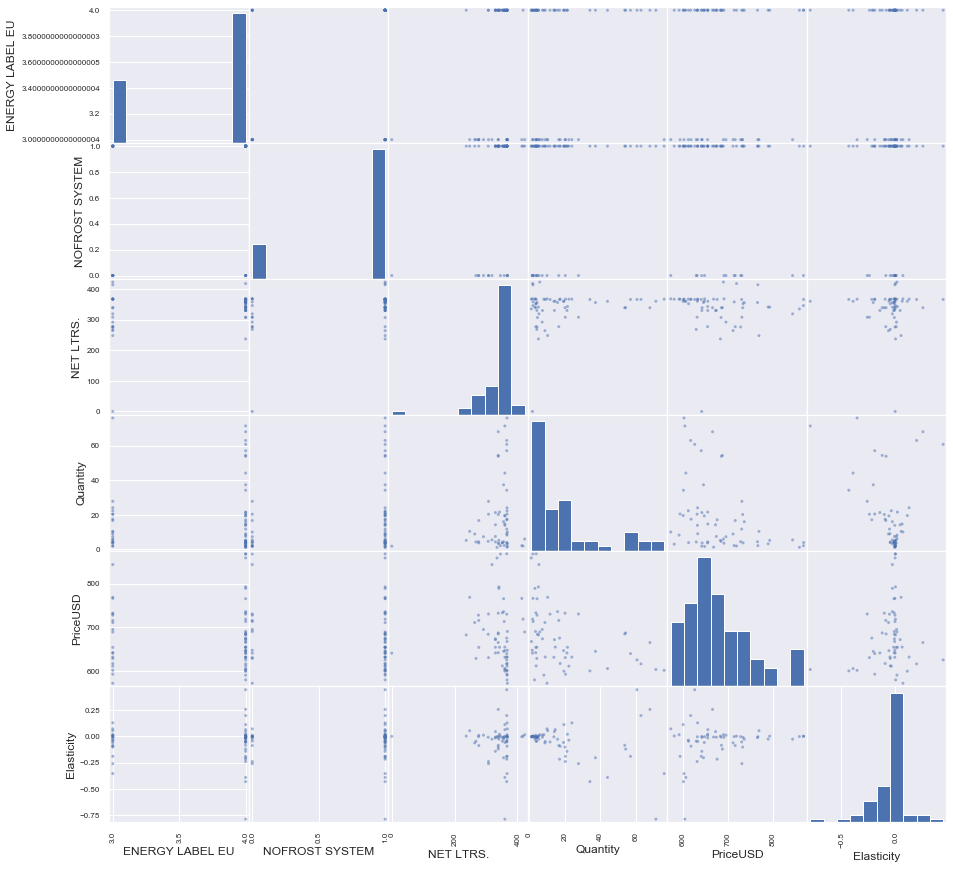

Кластер 2
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count        75.000000            75.0   75.000000   75.000000   75.000000   
mean          2.946667             0.0  146.333333   67.727842  173.387378   
std           0.279639             0.0   64.375657   77.312370   46.122170   
min           2.000000             0.0   42.000000    2.111111   90.809411   
25%           3.000000             0.0   93.000000    9.347917  143.363319   
50%           3.000000             0.0  136.000000   40.416667  169.148625   
75%           3.000000             0.0  207.000000  103.758260  208.987449   
max           4.000000             0.0  272.000000  297.395833  285.651268   

       Elasticity  
count   75.000000  
mean     0.013210  
std      1.960290  
min    -10.147207  
25%     -0.291498  
50%      0.030050  
75%      0.505490  
max      5.517989  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


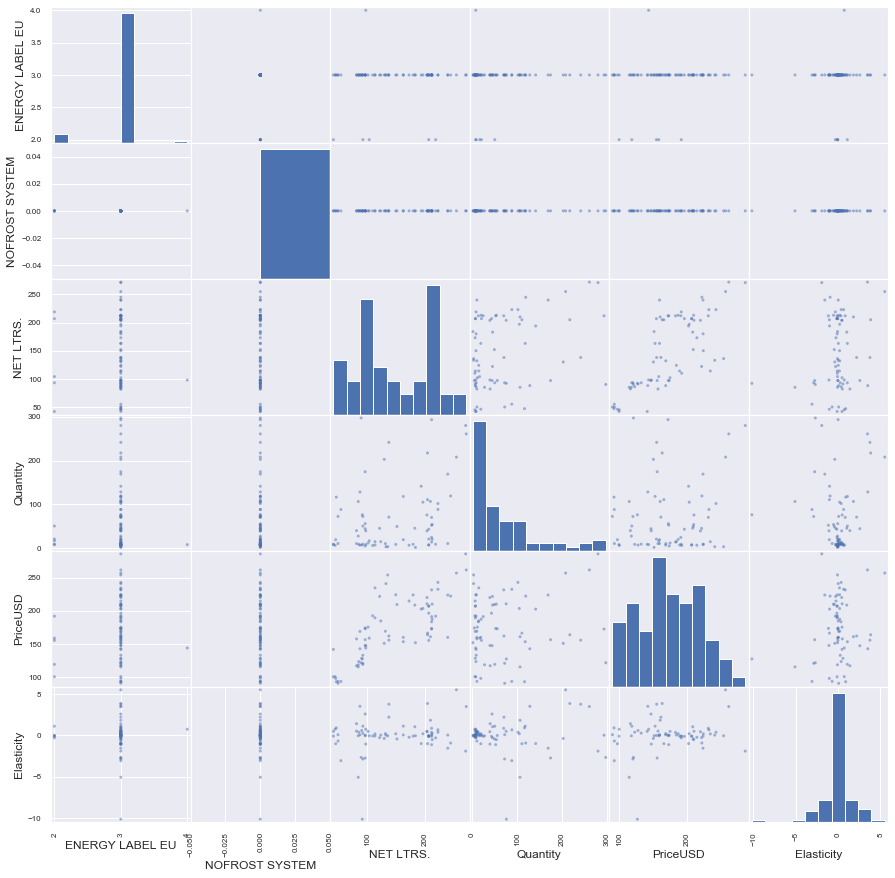

Кластер 3
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count       109.000000      109.000000  109.000000  109.000000  109.000000   
mean          2.944954        0.119266  321.660550   23.249983  345.923666   
std           0.524137        0.325598   27.466215   21.183045   33.403077   
min           1.000000        0.000000  265.000000    1.608333  290.269170   
25%           3.000000        0.000000  300.000000    6.807642  320.961590   
50%           3.000000        0.000000  321.000000   16.149495  343.008605   
75%           3.000000        0.000000  339.000000   31.632000  365.161989   
max           4.000000        1.000000  393.000000   92.000000  441.902643   

       Elasticity  
count  109.000000  
mean     0.076243  
std      0.416389  
min     -1.020821  
25%     -0.070628  
50%      0.021448  
75%      0.152978  
max      1.952064  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

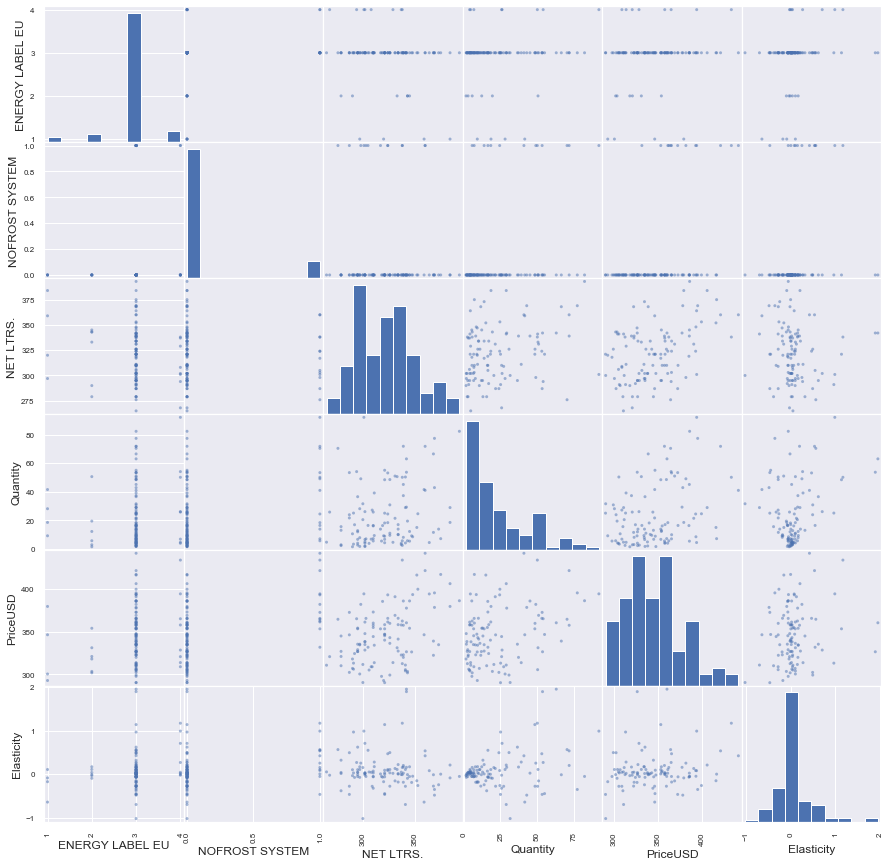

Кластер 4
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count        85.000000       85.000000   85.000000   85.000000   85.000000   
mean          2.870588        0.023529  271.388235   43.363578  278.910173   
std           0.430621        0.152477   45.164012   46.367122   37.528212   
min           1.000000        0.000000  106.000000    1.555556  203.463637   
25%           3.000000        0.000000  243.000000    6.969697  254.881972   
50%           3.000000        0.000000  277.000000   20.503352  274.119995   
75%           3.000000        0.000000  305.000000   78.500000  301.234472   
max           4.000000        1.000000  359.000000  193.333333  380.071389   

       Elasticity  
count   85.000000  
mean     0.045833  
std      0.750525  
min     -2.814364  
25%     -0.137859  
50%      0.026943  
75%      0.279818  
max      2.055882  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

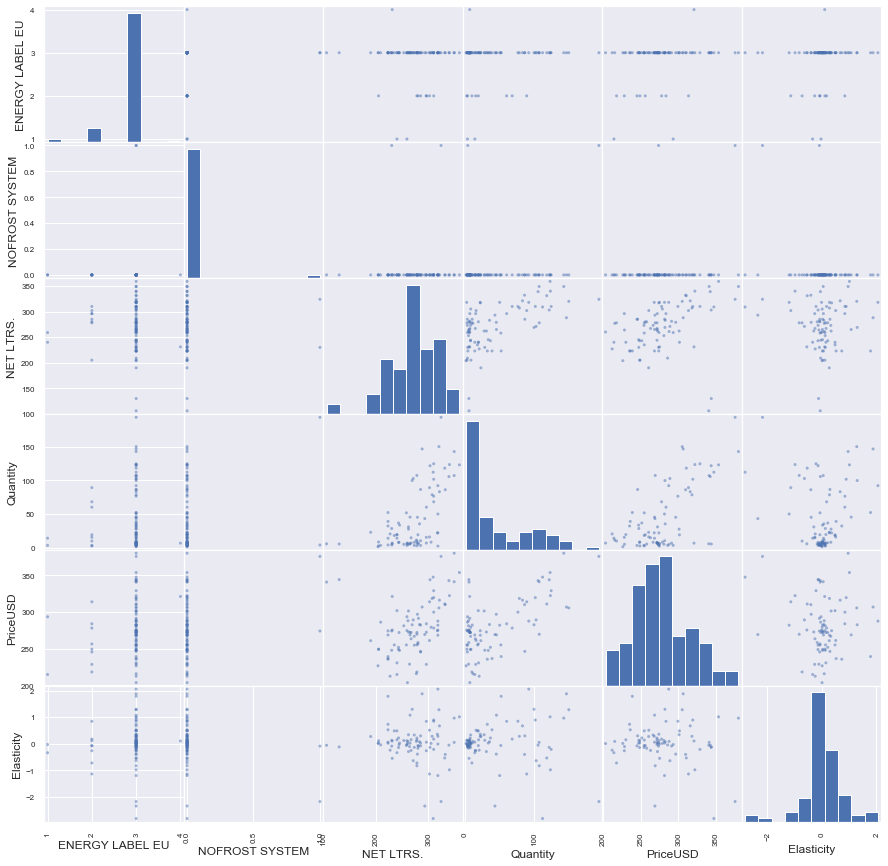

Кластер 5
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.   Quantity    PriceUSD  \
count        67.000000       67.000000   67.000000  67.000000   67.000000   
mean          3.358209        0.850746  337.507463  20.114630  545.315424   
std           0.483093        0.359028   59.862057  17.472807   41.283107   
min           3.000000        0.000000  260.000000   2.033333  460.806443   
25%           3.000000        1.000000  304.000000   6.668141  525.479947   
50%           3.000000        1.000000  328.000000  14.433333  546.040641   
75%           4.000000        1.000000  352.500000  28.203157  578.528128   
max           4.000000        1.000000  527.000000  73.958333  624.540820   

       Elasticity  
count   67.000000  
mean     0.127596  
std      0.531285  
min     -0.952429  
25%     -0.023310  
50%      0.022847  
75%      0.065381  
max      2.876504  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000        0.0

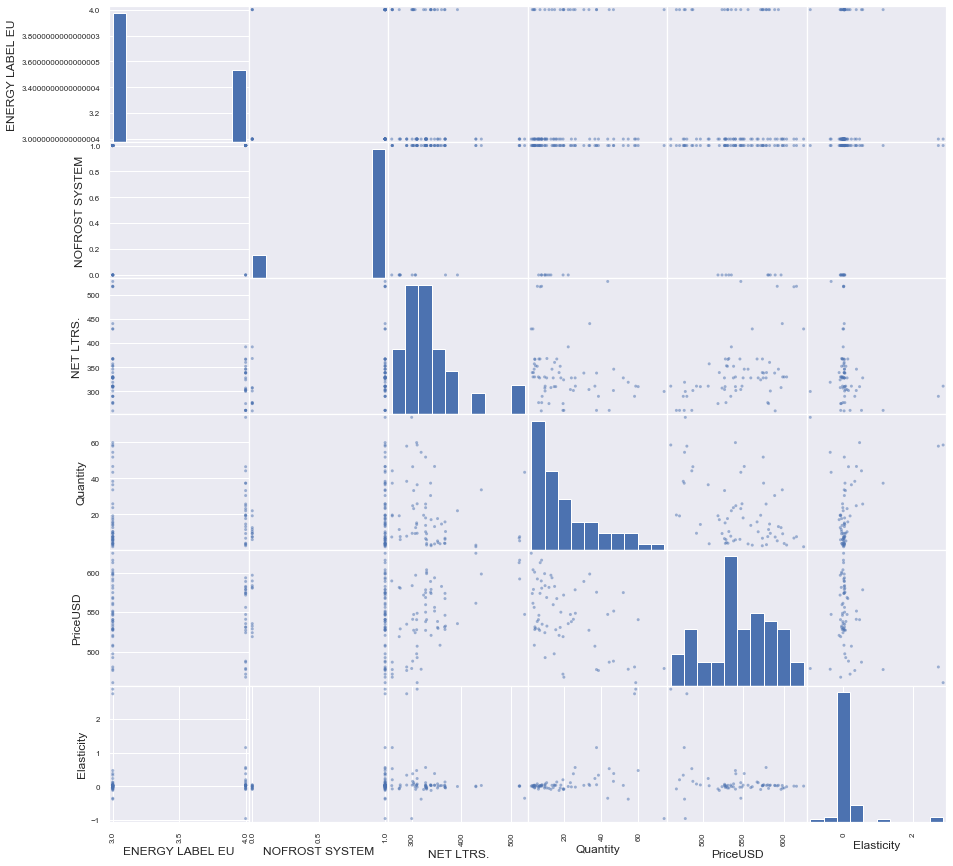

Кластер 6
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity     PriceUSD  \
count        81.000000       81.000000   81.000000   81.000000    81.000000   
mean          3.617284        0.950617  465.222222   18.586802  1077.867289   
std           0.662720        0.218016  107.904472   26.594178   281.853942   
min           2.000000        0.000000  255.000000    1.363636   726.350125   
25%           3.000000        1.000000  366.000000    3.187500   879.954828   
50%           4.000000        1.000000  468.000000    6.786233  1002.493149   
75%           4.000000        1.000000  540.000000   20.783333  1213.667434   
max           5.000000        1.000000  651.000000  101.110833  1760.766922   

       Elasticity  
count   81.000000  
mean    -0.048126  
std      0.187744  
min     -0.809636  
25%     -0.034118  
50%     -0.008155  
75%      0.004810  
max      0.462785  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1

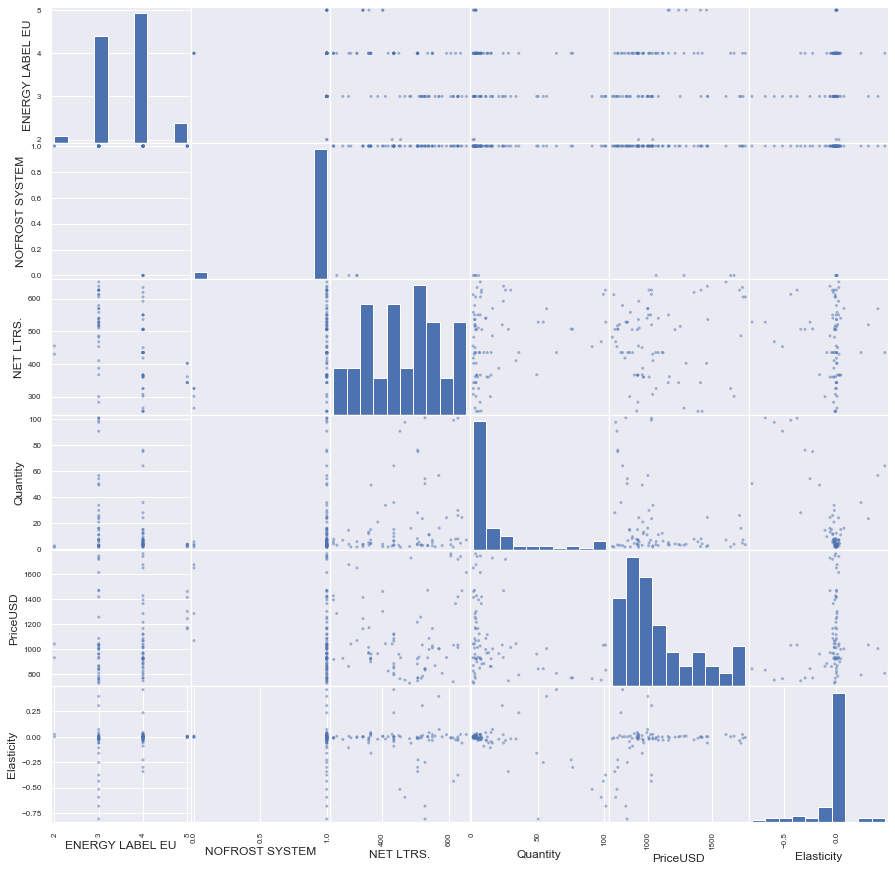

Кластер 7
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count        33.000000       33.000000   33.000000   33.000000   33.000000   
mean          3.424242        0.848485  333.363636  304.665280  516.297136   
std           0.501890        0.364110   35.333959  197.370303  100.852074   
min           3.000000        0.000000  245.000000   94.750000  231.121140   
25%           3.000000        1.000000  302.000000  159.116100  476.740078   
50%           3.000000        1.000000  346.000000  238.416667  522.939124   
75%           4.000000        1.000000  366.000000  382.475000  573.781689   
max           4.000000        1.000000  384.000000  857.768597  678.583340   

       Elasticity  
count   33.000000  
mean    -0.600415  
std      2.652772  
min    -11.815988  
25%     -1.313208  
50%     -0.251111  
75%      0.691027  
max      2.804369  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

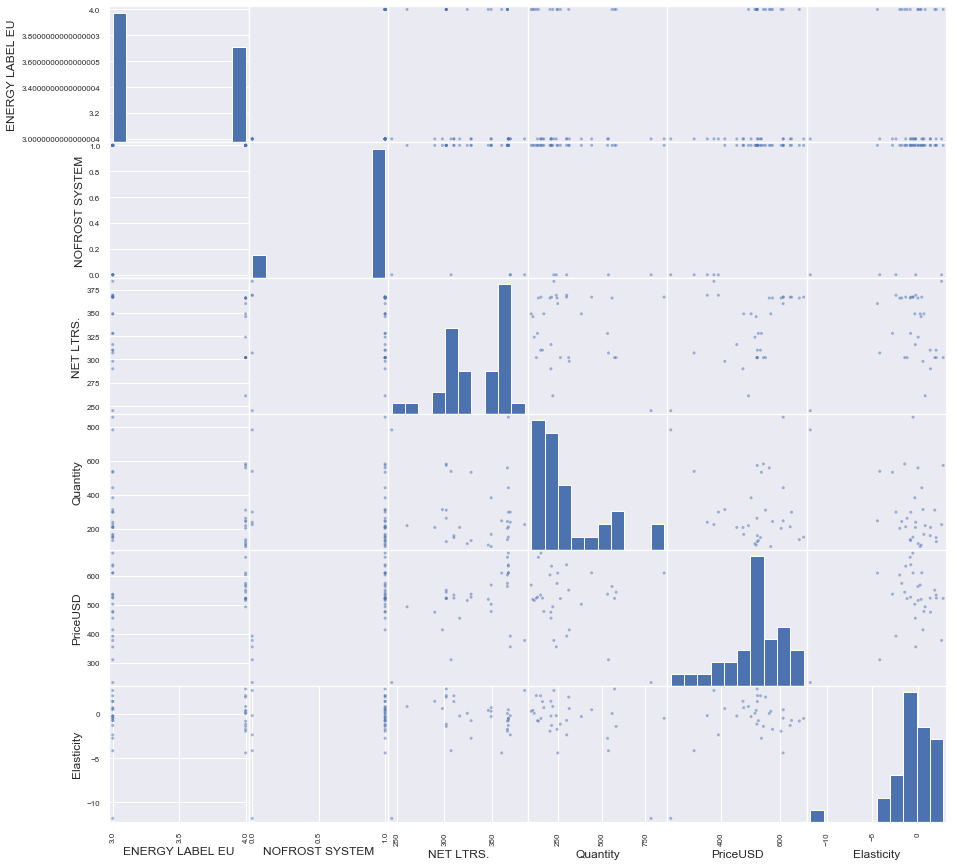

Кластер 8
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.   Quantity    PriceUSD  \
count        95.000000       95.000000   95.000000  95.000000   95.000000   
mean          3.210526        0.768421  312.473684  10.946236  434.222205   
std           0.481459        0.424079   35.717819   8.582828   33.258001   
min           2.000000        0.000000  224.000000   1.777778  341.340315   
25%           3.000000        1.000000  299.500000   4.665956  415.798414   
50%           3.000000        1.000000  310.000000   7.708333  437.150839   
75%           3.000000        1.000000  338.000000  15.804731  456.712856   
max           4.000000        1.000000  428.000000  41.083333  497.730882   

       Elasticity  
count   95.000000  
mean     0.005614  
std      0.119073  
min     -0.503089  
25%     -0.039911  
50%      0.005112  
75%      0.067997  
max      0.335390  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000       -0.3

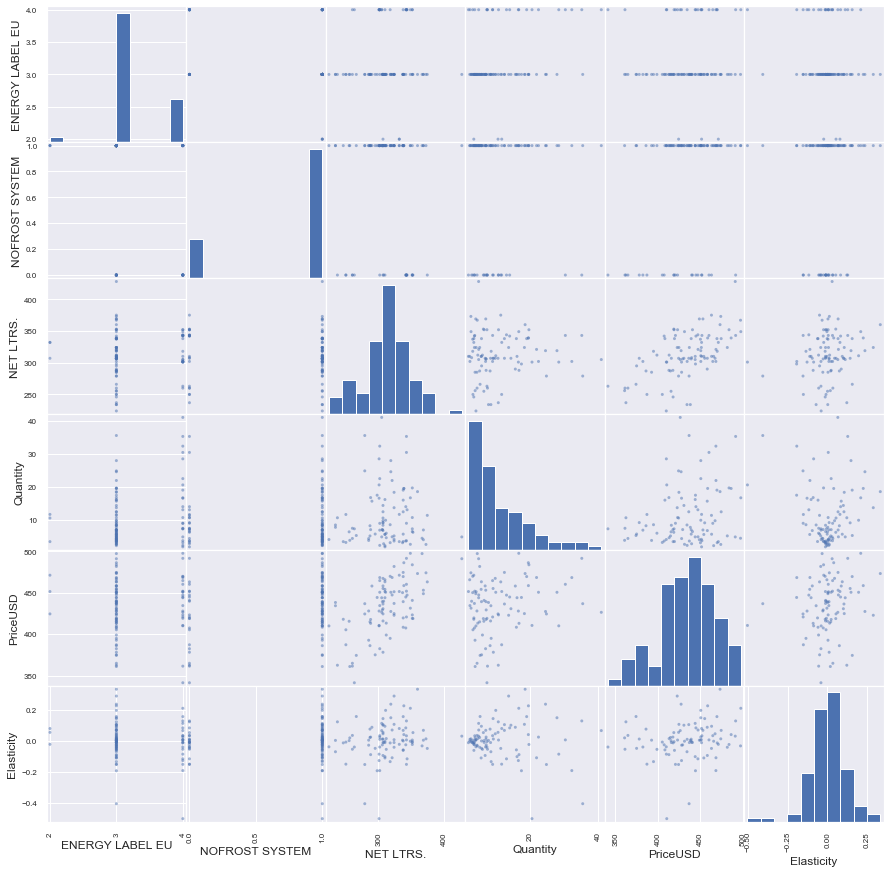

In [30]:
for i in np.unique(km.labels_+1):# виведемо відомості по класам
    print('Кластер ' + str(i))
    print(data[data['cluster_kmean_t_sne']==i][['ENERGY LABEL EU', 'NOFROST SYSTEM', 'NET LTRS.', 'Quantity', 'PriceUSD', 'Elasticity']].describe())
    print(data[data['cluster_kmean_t_sne']==i][['ENERGY LABEL EU', 'NOFROST SYSTEM', 'NET LTRS.', 'Quantity', 'PriceUSD', 'Elasticity']].corr())
    scatter_matrix(data[data['cluster_kmean_t_sne']==i][['ENERGY LABEL EU', 'NOFROST SYSTEM', 'NET LTRS.', 'Quantity', 'PriceUSD', 'Elasticity']], cmap='flag', figsize=(15,15)) 
    plt.show()

In [ ]:
Далі побудуємо кластеризації за допомогою ієрархічного методу

In [31]:
def fancy_dendrogram(*args, **kwargs):#функія побудови дендрограми
    sns.set()
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    ddata = dendrogram(*args, **kwargs)
    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [32]:
def lokot(data_linkage):# метод ліктя - найбільш оптимальна кількість сегментів
    last = data_linkage[-20:, 2] 
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)
    plt.plot(idxs, last_rev)
    acceleration = np.diff(last, 2)  
    acceleration_rev = acceleration[::-1]
    plt.plot(idxs[:-2] + 1, acceleration_rev)
    plt.show()
    k = acceleration_rev.argmax() + 2 
    print("clusters:", k)

In [ ]:
#пошук кращої моделі
for method in ['ward','centroid', 'weighted', 'average', 'complete']:# за допомогою цього отримуємо оцінки для всіх комбінацій
    for metric in ['sqeuclidean','euclidean','cityblock','seuclidean','cosine','correlation','hamming','chebyshev','canberra','braycurtis']:
        try:
            print(method + ' ' + metric)
            print('Можлива к-ть класів')
            for i in range(2,20):
                dist = pdist(dataNorm, metric)
                link = linkage(dist, method=method)
                cluster=fcluster(link, i, criterion='maxclust')
                c = silhouette_score(dataNorm, cluster, metric=metric)
                ch = calinski_harabasz_score(dataNorm, cluster)
                db = davies_bouldin_score(dataNorm, cluster)
                if(c>0):
                    print('Clusters: ' + str(i) + '\nsilhouette_score: ' + str(c) + '\ncalinski harabasz score: ' + str(ch) + '\ndavies_bouldin_score: ' + str(db))
        except Exception:
            pass

In [33]:
data_dist = pdist(dataNorm, 'cosine') # побудова матриці відстаней

In [34]:
data_linkage = linkage(data_dist, method='centroid') # об'єднання елементів у кластери

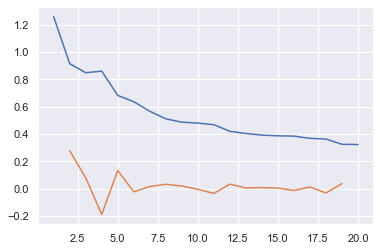

clusters: 2


In [35]:
lokot(data_linkage)

In [36]:
clustering_criterion_ierarhi(dataNorm, 'centroid', 'cosine')

Можлива к-ть класів
Clusters: 2
silhouette_score: 0.5669138217006955
calinski harabasz score: 228.34975800179905
davies_bouldin_score: 1.2890345147256181
Clusters: 3
silhouette_score: 0.45852558652957276
calinski harabasz score: 144.2264033678575
davies_bouldin_score: 1.2124694516178829
Clusters: 4
silhouette_score: 0.4585255865295727
calinski harabasz score: 144.2264033678575
davies_bouldin_score: 1.2124694516178829
Clusters: 5
silhouette_score: 0.5413053616886055
calinski harabasz score: 155.4322270824005
davies_bouldin_score: 1.1932427354528794
Clusters: 6
silhouette_score: 0.5486622261740697
calinski harabasz score: 140.02673800450356
davies_bouldin_score: 1.122384799304198
Clusters: 7
silhouette_score: 0.5698705098890386
calinski harabasz score: 144.22129875874177
davies_bouldin_score: 1.0337332260164043
Clusters: 8
silhouette_score: 0.5480395353967492
calinski harabasz score: 128.52332290563604
davies_bouldin_score: 0.9808738861198384
Clusters: 9
silhouette_score: 0.4868587662532

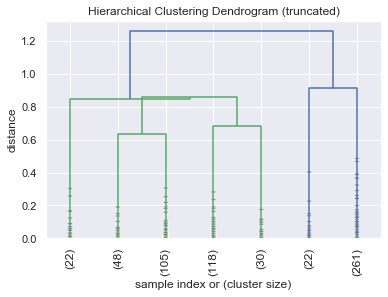

In [37]:
nCluster=7# побудова нашої дендрограми за вказаною к-тю кластерів дла ієрархічного методу
fancy_dendrogram(
    data_linkage,
    truncate_mode='lastp',
    p=nCluster, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
)
plt.show()

In [38]:
clusters=fcluster(data_linkage, nCluster, criterion='maxclust')

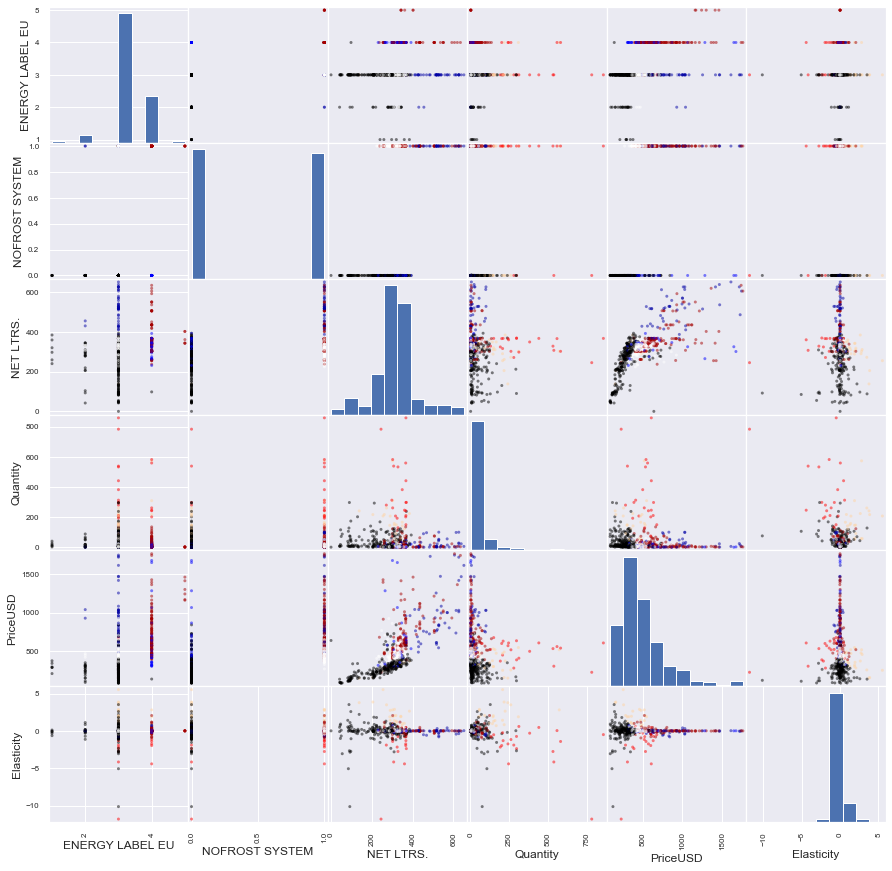

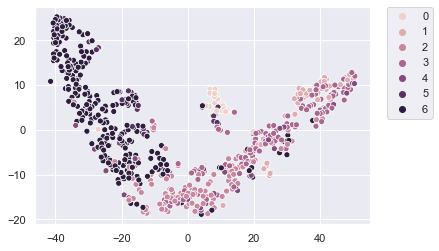

In [39]:
scatter_matrix(data_for_clust, c=clusters, cmap='flag', figsize=(15,15)) 
plt.show()
sns.scatterplot(digits_proj[:,0], digits_proj[:,1], hue=clusters-1, legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [40]:
data['cluster_ier_centr_cos_7']=clusters

Кластер 1
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count        22.000000       22.000000   22.000000   22.000000   22.000000   
mean          3.272727        0.818182  336.318182  354.002443  509.559359   
std           0.455842        0.394771   36.562258  208.263172  125.175669   
min           3.000000        0.000000  245.000000   76.018924  231.121140   
25%           3.000000        1.000000  309.250000  208.828125  423.202172   
50%           3.000000        1.000000  354.500000  288.916667  539.973524   
75%           3.750000        1.000000  367.000000  509.989417  607.789124   
max           4.000000        1.000000  369.000000  857.768597  678.583340   

       Elasticity  
count   22.000000  
mean    -1.802748  
std      2.594454  
min    -11.815988  
25%     -2.123372  
50%     -1.239588  
75%     -0.390994  
max      0.586154  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

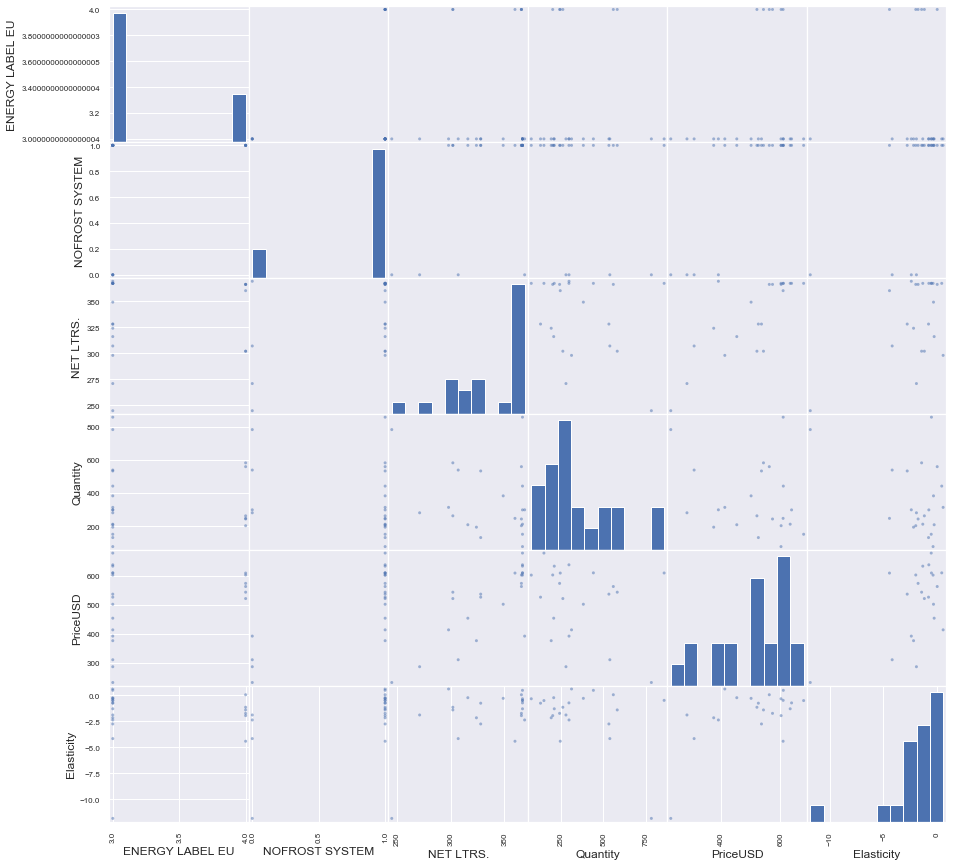

Кластер 2
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity     PriceUSD  \
count        48.000000            48.0   48.000000   48.000000    48.000000   
mean          2.958333             1.0  501.979167   24.533960   922.625076   
std           0.201941             0.0   85.116063   29.463240   333.786036   
min           2.000000             1.0  367.000000    1.363636   491.198680   
25%           3.000000             1.0  429.000000    3.140625   630.552713   
50%           3.000000             1.0  517.000000   13.463836   841.359238   
75%           3.000000             1.0  560.750000   30.735321  1031.190733   
max           3.000000             1.0  651.000000  101.110833  1743.024314   

       Elasticity  
count   48.000000  
mean    -0.075145  
std      0.224697  
min     -0.809636  
25%     -0.061838  
50%     -0.010624  
75%      0.012841  
max      0.396754  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1

c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:81: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:71: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


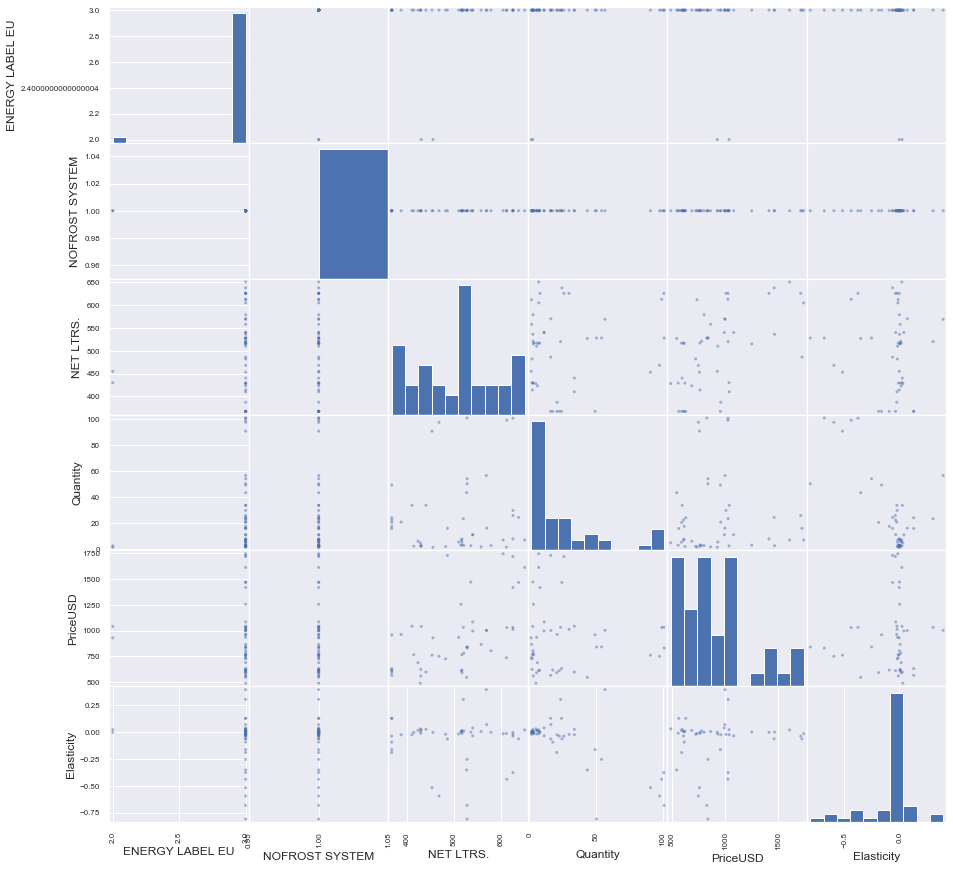

Кластер 3
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count       105.000000           105.0  105.000000  105.000000  105.000000   
mean          2.971429             1.0  313.361905   14.701836  475.479194   
std           0.167398             0.0   32.031572   14.952648  100.157357   
min           2.000000             1.0  224.000000    2.144444  273.862688   
25%           3.000000             1.0  298.000000    5.104127  419.644635   
50%           3.000000             1.0  312.000000    8.916667  451.300685   
75%           3.000000             1.0  332.000000   18.054027  520.647916   
max           3.000000             1.0  373.000000   71.750000  924.506773   

       Elasticity  
count  105.000000  
mean     0.036781  
std      0.165490  
min     -0.466011  
25%     -0.037868  
50%      0.008372  
75%      0.080826  
max      0.563488  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

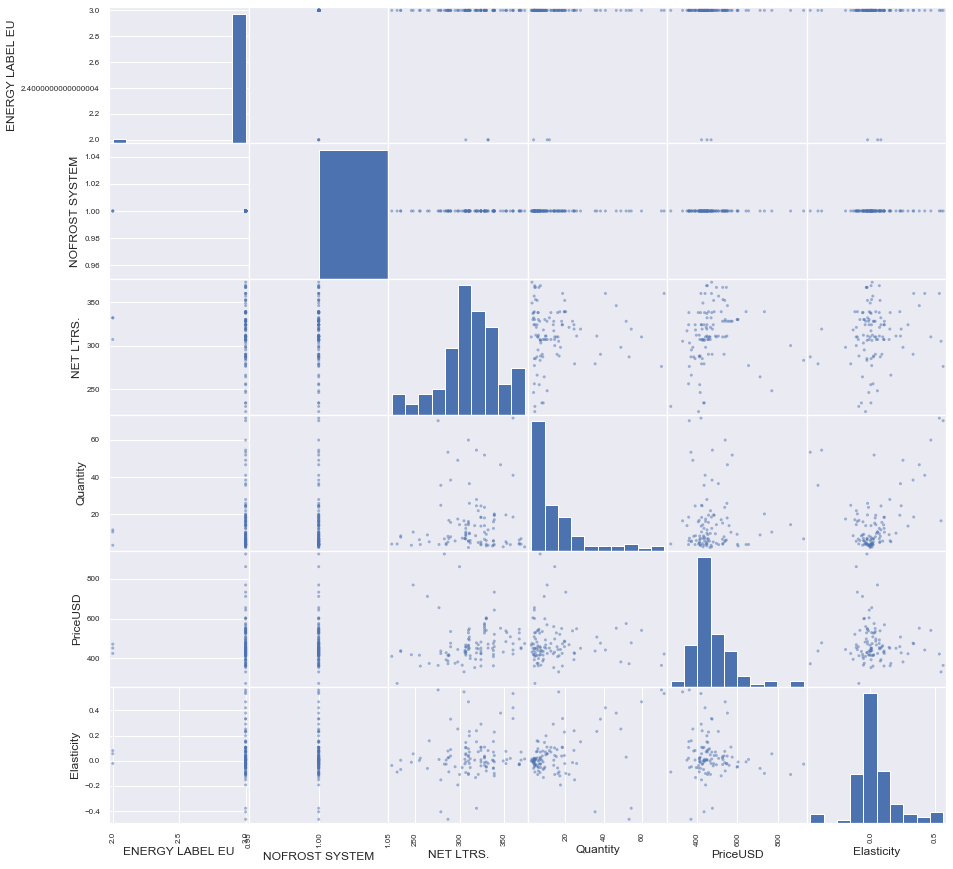

Кластер 4
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity     PriceUSD  \
count       118.000000           118.0  118.000000  118.000000   118.000000   
mean          4.050847             1.0  369.788136   23.075839   757.062805   
std           0.220623             0.0   79.736730   28.055547   285.494097   
min           4.000000             1.0  237.000000    1.222222   394.313494   
25%           4.000000             1.0  328.500000    4.006639   568.940382   
50%           4.000000             1.0  356.000000   12.615959   666.875033   
75%           4.000000             1.0  367.000000   29.997917   917.914195   
max           5.000000             1.0  634.000000  135.800000  1760.766922   

       Elasticity  
count  118.000000  
mean     0.032751  
std      0.330909  
min     -0.952429  
25%     -0.035380  
50%      0.000056  
75%      0.033613  
max      2.056106  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1

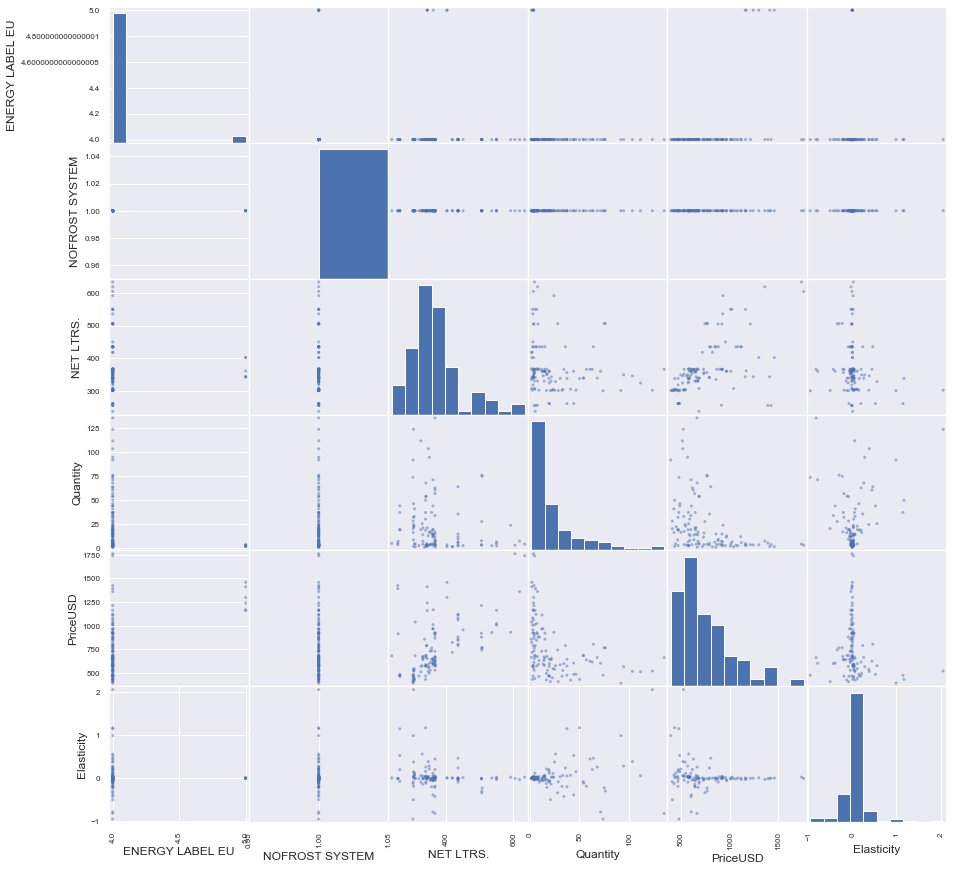

Кластер 5
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.   Quantity     PriceUSD  \
count             30.0            30.0   30.000000  30.000000    30.000000   
mean               4.0             0.0  320.066667  11.850286   596.404006   
std                0.0             0.0   38.055253  12.196419   366.303747   
min                4.0             0.0  231.000000   1.666667   308.945881   
25%                4.0             0.0  301.250000   3.643939   362.336039   
50%                4.0             0.0  327.000000   7.250000   451.760081   
75%                4.0             0.0  343.750000  13.739583   643.943509   
max                4.0             0.0  392.000000  54.091667  1673.411397   

       Elasticity  
count   30.000000  
mean     0.022316  
std      0.154978  
min     -0.238619  
25%     -0.010728  
50%     -0.002148  
75%      0.015321  
max      0.706790  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU              NaN  

c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:71: UserWarning: Attempting to set identical left == right == 4.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])
c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:81: UserWarning: Attempting to set identical bottom == top == 4.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left == right == 4.0 results in singular transformations; automatically expanding.
  ax.set_xlim(

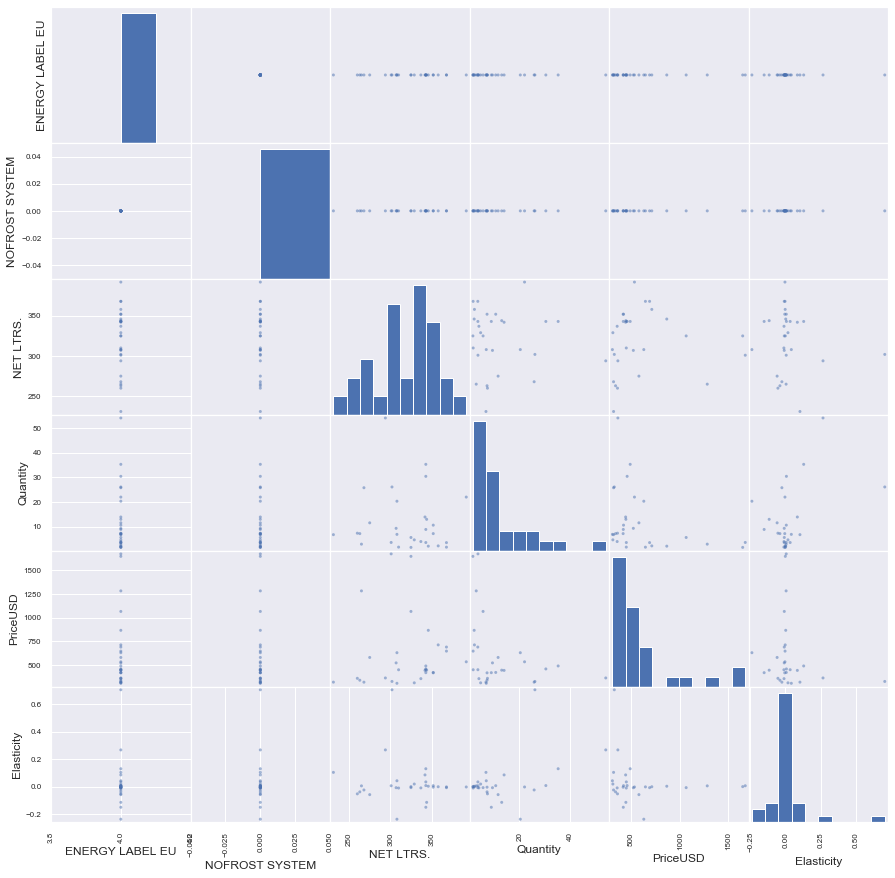

Кластер 6
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count        22.000000       22.000000   22.000000   22.000000   22.000000   
mean          3.136364        0.409091  300.818182  175.941286  381.878861   
std           0.351250        0.503236   53.580946  115.576969  117.735676   
min           3.000000        0.000000  138.000000   48.423690  155.738587   
25%           3.000000        0.000000  288.500000   99.734998  305.680350   
50%           3.000000        0.000000  310.000000  154.473088  368.433587   
75%           3.000000        1.000000  336.750000  218.005857  479.664460   
max           4.000000        1.000000  384.000000  573.212532  550.397043   

       Elasticity  
count   22.000000  
mean     2.185834  
std      1.194439  
min      0.691027  
25%      1.304524  
50%      1.923272  
75%      2.788067  
max      5.517989  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

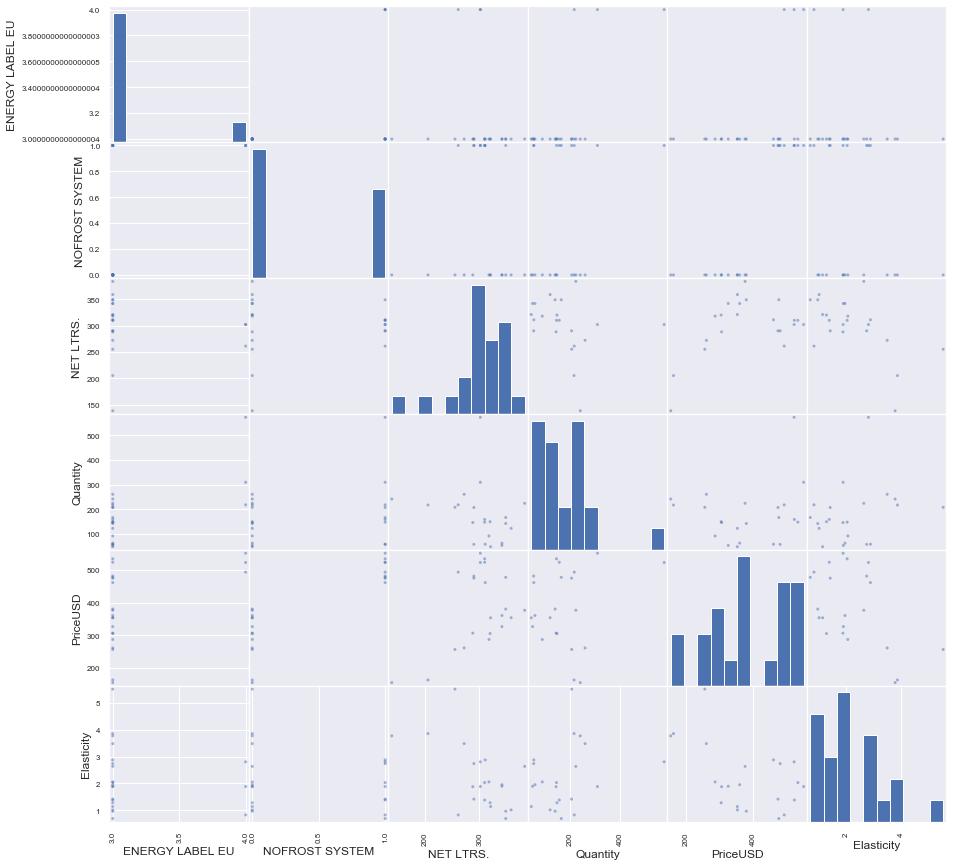

Кластер 7
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count       261.000000           261.0  261.000000  261.000000  261.000000   
mean          2.885057             0.0  254.593870   34.091824  294.901873   
std           0.394928             0.0   87.070947   44.999400  117.577168   
min           1.000000             0.0    0.000000    1.555556   90.809411   
25%           3.000000             0.0  212.000000    7.066667  222.065983   
50%           3.000000             0.0  279.000000   15.125000  292.798073   
75%           3.000000             0.0  318.000000   45.124226  344.292004   
max           4.000000             0.0  393.000000  297.395833  843.391854   

       Elasticity  
count  261.000000  
mean    -0.067292  
std      0.972282  
min    -10.147207  
25%     -0.137859  
50%      0.003940  
75%      0.153753  
max      3.517151  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

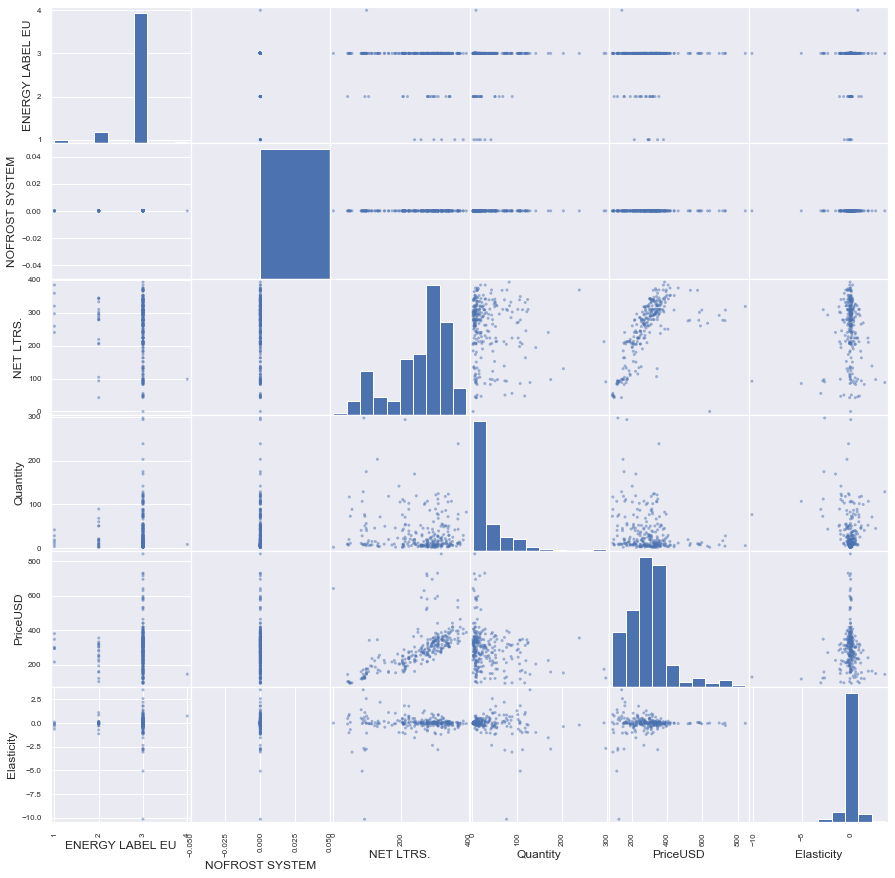

In [41]:
for i in np.unique(clusters):# виведемо відомості по класам
    print('Кластер ' + str(i))
    print(data[data['cluster_ier_centr_cos_7']==i][['ENERGY LABEL EU', 'NOFROST SYSTEM', 'NET LTRS.', 'Quantity', 'PriceUSD', 'Elasticity']].describe())
    print(data[data['cluster_ier_centr_cos_7']==i][['ENERGY LABEL EU', 'NOFROST SYSTEM', 'NET LTRS.', 'Quantity', 'PriceUSD', 'Elasticity']].corr())
    scatter_matrix(data[data['cluster_ier_centr_cos_7']==i][['ENERGY LABEL EU', 'NOFROST SYSTEM', 'NET LTRS.', 'Quantity', 'PriceUSD', 'Elasticity']], cmap='flag', figsize=(15,15)) 
    plt.show()

In [ ]:
Розглянемо те саме але для T-SNE(Найкраща і кінцева кластеризація)

In [42]:
data_dist = pdist(digits_proj_norm, 'sqeuclidean') # побудова матриці відстаней

In [43]:
data_linkage = linkage(data_dist, method='average') # об'єднання елементів у кластери

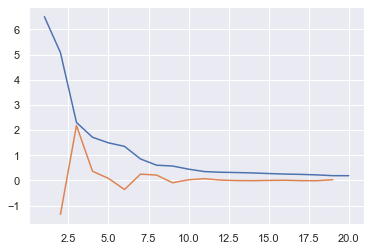

clusters: 3


In [44]:
lokot(data_linkage)

In [45]:
clustering_criterion_ierarhi(digits_proj_norm, 'average', 'sqeuclidean')

Можлива к-ть класів
Clusters: 2
silhouette_score: 0.6064317054983752
calinski harabasz score: 504.9273221502503
davies_bouldin_score: 0.7847306500400807
Clusters: 3
silhouette_score: 0.5930232903369808
calinski harabasz score: 680.5723299564281
davies_bouldin_score: 0.6418901134722229
Clusters: 4
silhouette_score: 0.6210767757769329
calinski harabasz score: 810.2591960222276
davies_bouldin_score: 0.7862209666697724
Clusters: 5
silhouette_score: 0.5504544673907119
calinski harabasz score: 841.3173066494696
davies_bouldin_score: 0.7489013708384811
Clusters: 6
silhouette_score: 0.5881723468816864
calinski harabasz score: 1040.7518958661346
davies_bouldin_score: 0.6644564364971594
Clusters: 7
silhouette_score: 0.6218826357042444
calinski harabasz score: 1130.737872515737
davies_bouldin_score: 0.6239071861706859
Clusters: 8
silhouette_score: 0.6508954634606645
calinski harabasz score: 1252.5187963054007
davies_bouldin_score: 0.6004220067999733
Clusters: 9
silhouette_score: 0.653816499192840

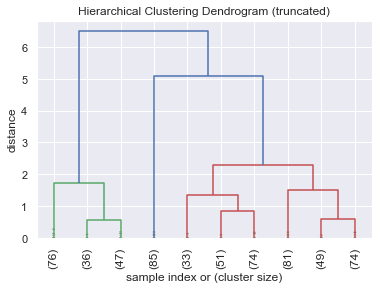

In [46]:
nCluster=10# побудова нашої дендрограми за вказаною к-тю кластерів дла ієрархічного методу
fancy_dendrogram(
    data_linkage,
    truncate_mode='lastp',
    p=nCluster, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
)
plt.show()

In [47]:
clusters=fcluster(data_linkage, nCluster, criterion='maxclust')

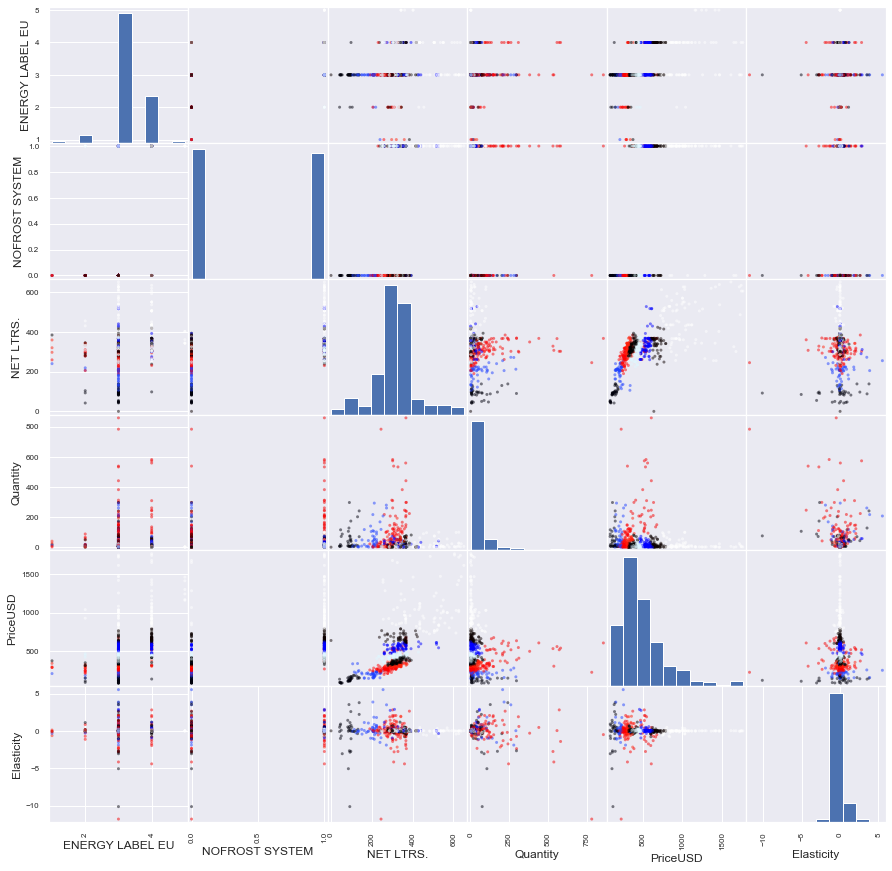

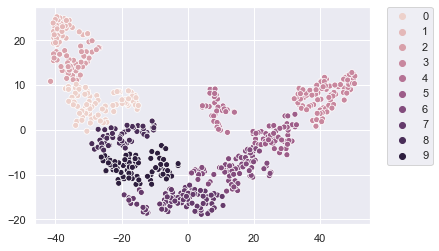

In [48]:
scatter_matrix(data_for_clust, c=clusters, cmap='flag', figsize=(15,15)) 
plt.show()
sns.scatterplot(digits_proj[:,0], digits_proj[:,1], hue=clusters-1, legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [49]:
data['cluster_ier_t_sne']=clusters

Кластер 1
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count        76.000000       76.000000   76.000000   76.000000   76.000000   
mean          2.881579        0.013158  278.526316   43.701732  280.041194   
std           0.398902        0.114708   37.029168   45.006484   33.494351   
min           1.000000        0.000000  190.000000    2.493056  203.463637   
25%           3.000000        0.000000  258.750000    6.992424  257.665073   
50%           3.000000        0.000000  278.000000   20.832692  274.408595   
75%           3.000000        0.000000  307.500000   83.746851  300.031481   
max           4.000000        1.000000  359.000000  149.830076  380.071389   

       Elasticity  
count   76.000000  
mean     0.049747  
std      0.715438  
min     -2.814364  
25%     -0.137772  
50%      0.040335  
75%      0.279784  
max      2.055882  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

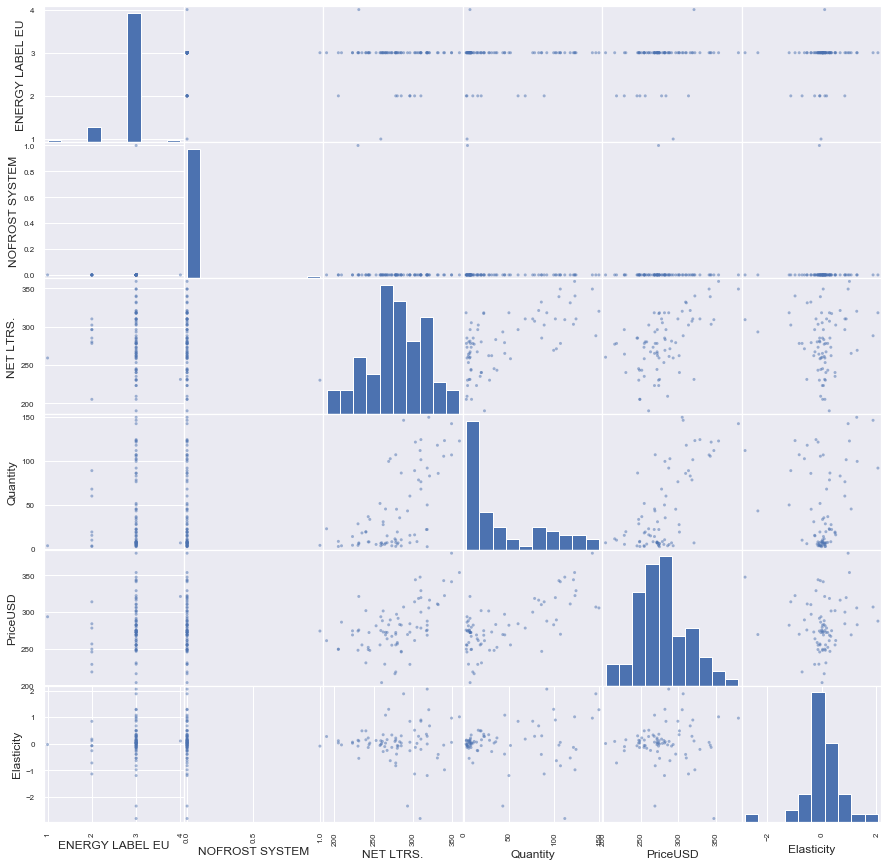

Кластер 2
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count        36.000000            36.0   36.000000   36.000000   36.000000   
mean          2.944444             0.0   88.916667   58.126965  138.575592   
std           0.333333             0.0   27.151822   72.049365   29.886921   
min           2.000000             0.0   42.000000    5.363636   90.809411   
25%           3.000000             0.0   82.000000    9.081250  118.256635   
50%           3.000000             0.0   92.500000   23.802064  142.313786   
75%           3.000000             0.0   99.000000   73.708896  159.583445   
max           4.000000             0.0  138.000000  297.395833  192.415491   

       Elasticity  
count   36.000000  
mean    -0.277794  
std      2.423144  
min    -10.147207  
25%     -0.453224  
50%      0.054589  
75%      0.626818  
max      3.772702  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
c:\users\zelen\desktop\python projects\lib\site-packages\pandas\plotting\_matplotlib\misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


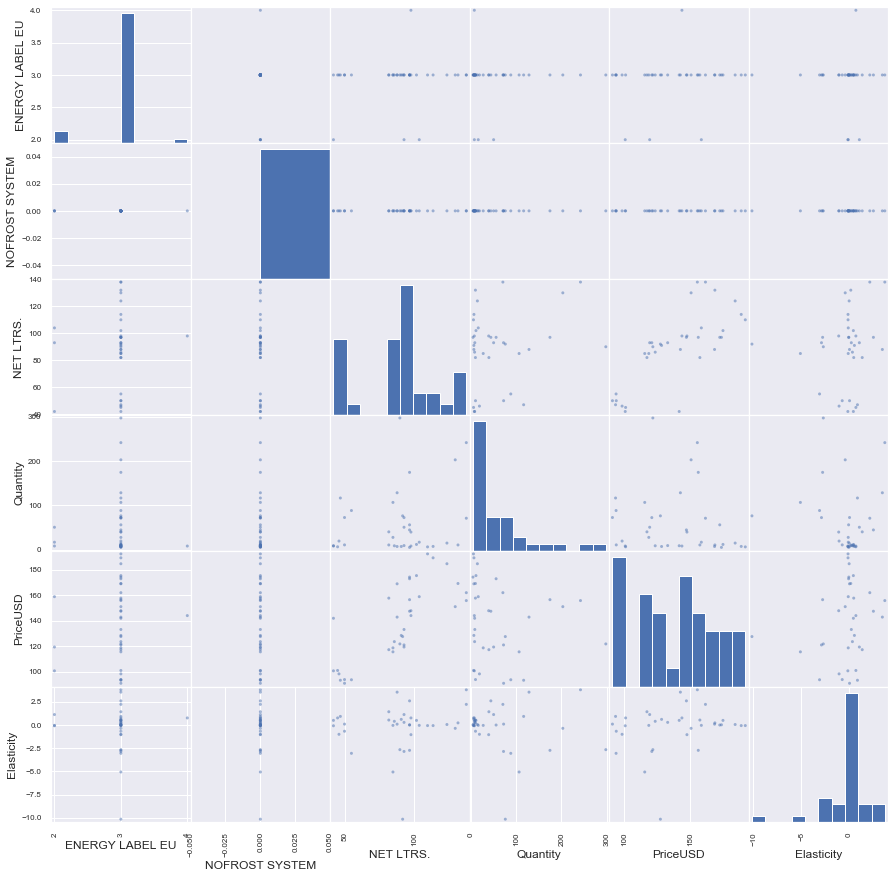

Кластер 3
       ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.    Quantity    PriceUSD  \
count        47.000000            47.0   47.00000   47.000000   47.000000   
mean          2.914894             0.0  198.93617   67.196949  214.125463   
std           0.350762             0.0   39.08486   77.568425   41.637129   
min           1.000000             0.0  106.00000    1.555556  151.928528   
25%           3.000000             0.0  181.50000   10.076786  189.204043   
50%           3.000000             0.0  207.00000   39.750000  212.215357   
75%           3.000000             0.0  223.00000  103.758260  233.381018   
max           3.000000             0.0  272.00000  293.499444  344.053057   

       Elasticity  
count   47.000000  
mean     0.282587  
std      1.289790  
min     -1.906452  
25%     -0.237148  
50%      0.010974  
75%      0.465502  
max      5.517989  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000           

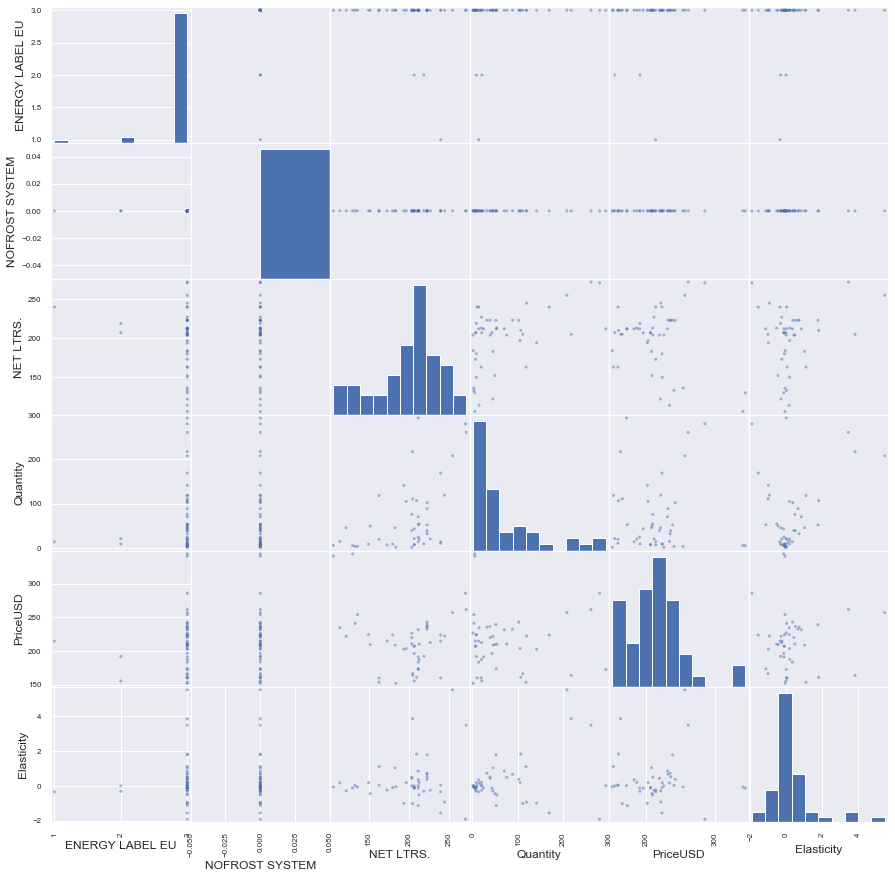

Кластер 4
       ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.    Quantity     PriceUSD  \
count        85.000000       85.000000    85.0000   85.000000    85.000000   
mean          3.623529        0.929412   459.4000   17.864207  1067.580807   
std           0.654226        0.257656   108.6161   26.161085   278.983128   
min           2.000000        0.000000   255.0000    1.222222   726.350125   
25%           3.000000        1.000000   366.0000    3.033333   866.392112   
50%           4.000000        1.000000   453.0000    6.083333   995.945190   
75%           4.000000        1.000000   540.0000   16.110487  1169.594063   
max           5.000000        1.000000   651.0000  101.110833  1760.766922   

       Elasticity  
count   85.000000  
mean    -0.046138  
std      0.183458  
min     -0.809636  
25%     -0.033269  
50%     -0.007560  
75%      0.002946  
max      0.462785  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

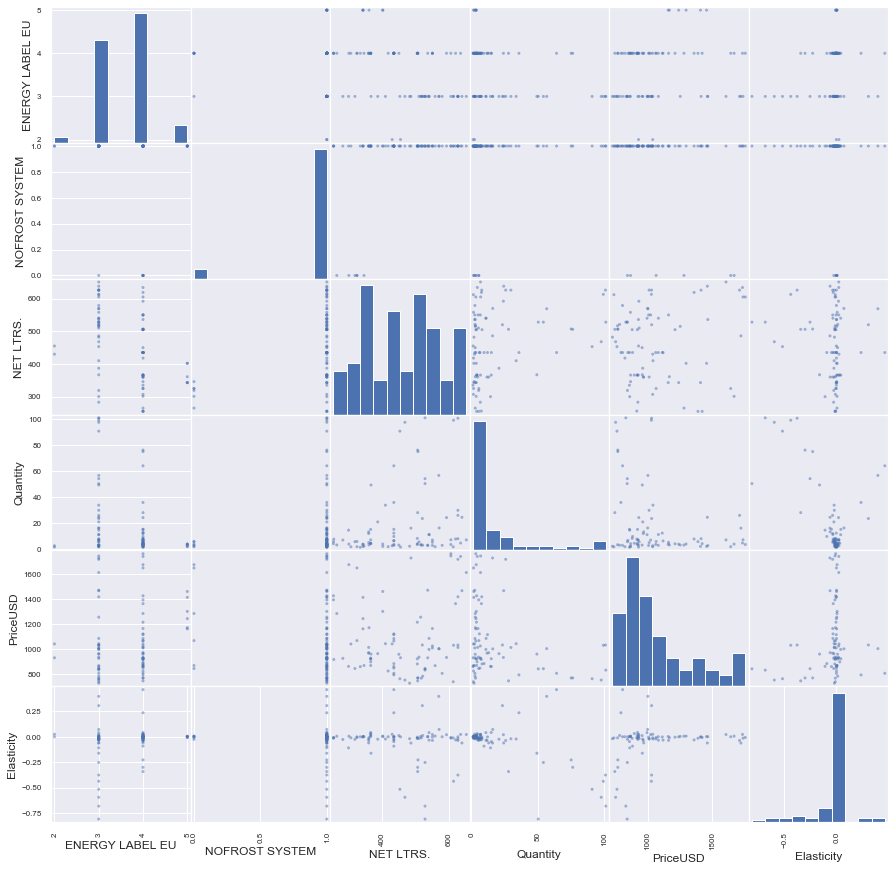

Кластер 5
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count        33.000000       33.000000   33.000000   33.000000   33.000000   
mean          3.424242        0.848485  333.363636  304.665280  516.297136   
std           0.501890        0.364110   35.333959  197.370303  100.852074   
min           3.000000        0.000000  245.000000   94.750000  231.121140   
25%           3.000000        1.000000  302.000000  159.116100  476.740078   
50%           3.000000        1.000000  346.000000  238.416667  522.939124   
75%           4.000000        1.000000  366.000000  382.475000  573.781689   
max           4.000000        1.000000  384.000000  857.768597  678.583340   

       Elasticity  
count   33.000000  
mean    -0.600415  
std      2.652772  
min    -11.815988  
25%     -1.313208  
50%     -0.251111  
75%      0.691027  
max      2.804369  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

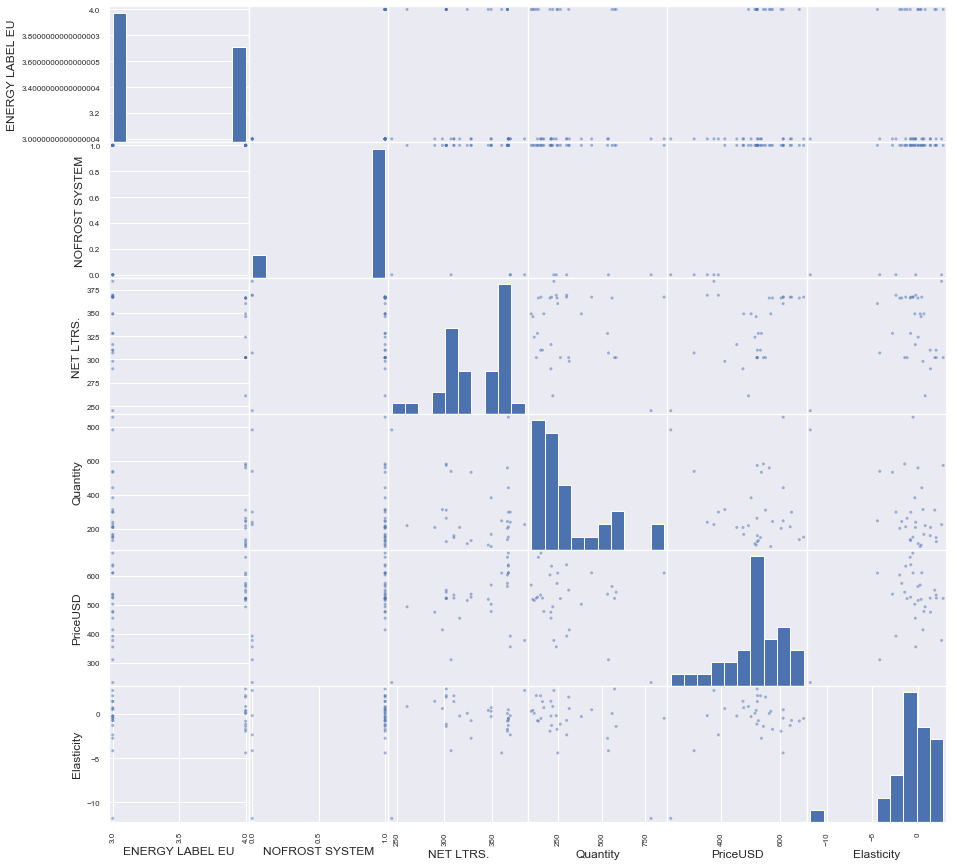

Кластер 6
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.   Quantity    PriceUSD  \
count        51.000000       51.000000   51.000000  51.000000   51.000000   
mean          3.666667        0.803922  334.666667  20.221764  676.073761   
std           0.476095        0.400979   62.242001  21.193148   51.115533   
min           3.000000        0.000000    0.000000   1.333333  601.150542   
25%           3.000000        1.000000  330.000000   4.409091  636.679708   
50%           4.000000        1.000000  356.000000  13.941742  668.040108   
75%           4.000000        1.000000  366.000000  23.222841  714.859905   
max           4.000000        1.000000  423.000000  76.018924  792.491439   

       Elasticity  
count   51.000000  
mean    -0.056104  
std      0.177882  
min     -0.786454  
25%     -0.089708  
50%     -0.008914  
75%      0.002599  
max      0.444387  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000        0.2

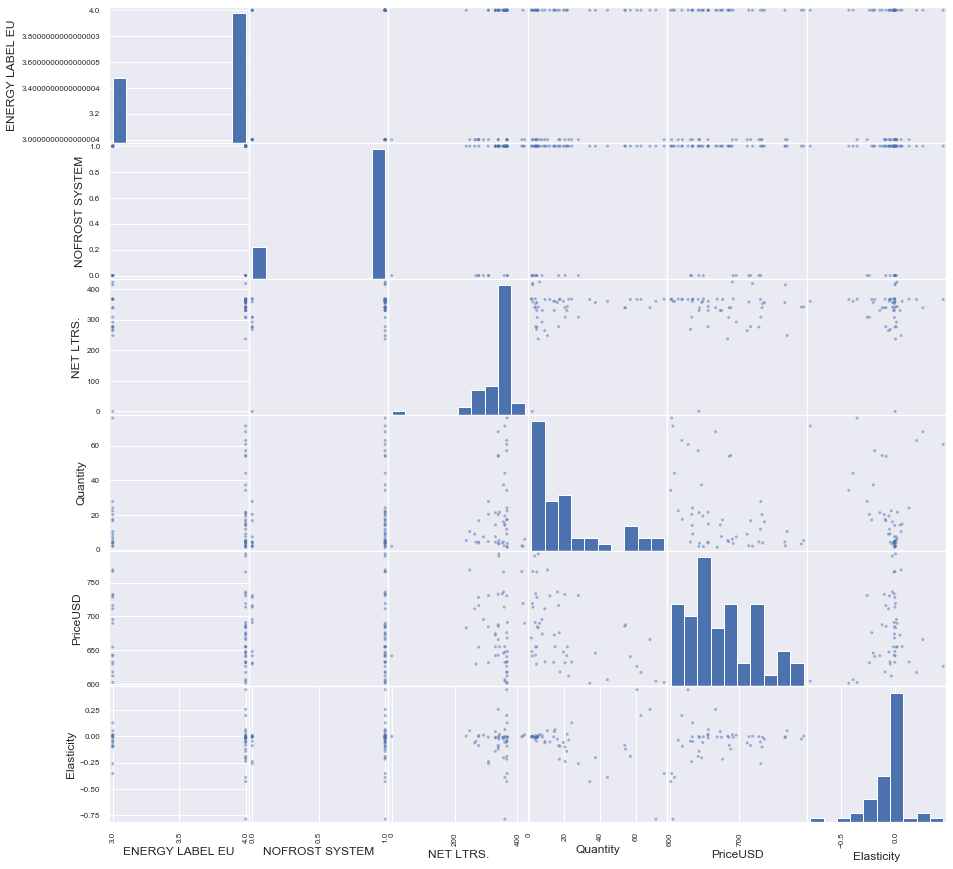

Кластер 7
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.   Quantity    PriceUSD  \
count        74.000000       74.000000   74.000000  74.000000   74.000000   
mean          3.391892        0.851351  339.135135  19.533949  548.056106   
std           0.491505        0.358170   57.556244  16.988376   42.501734   
min           3.000000        0.000000  260.000000   2.033333  460.806443   
25%           3.000000        1.000000  304.750000   6.615545  526.988272   
50%           3.000000        1.000000  329.000000  14.171789  547.874954   
75%           4.000000        1.000000  360.000000  25.876263  581.155999   
max           4.000000        1.000000  527.000000  73.958333  624.540820   

       Elasticity  
count   74.000000  
mean     0.112545  
std      0.508500  
min     -0.952429  
25%     -0.028728  
50%      0.022325  
75%      0.067449  
max      2.876504  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000        0.1

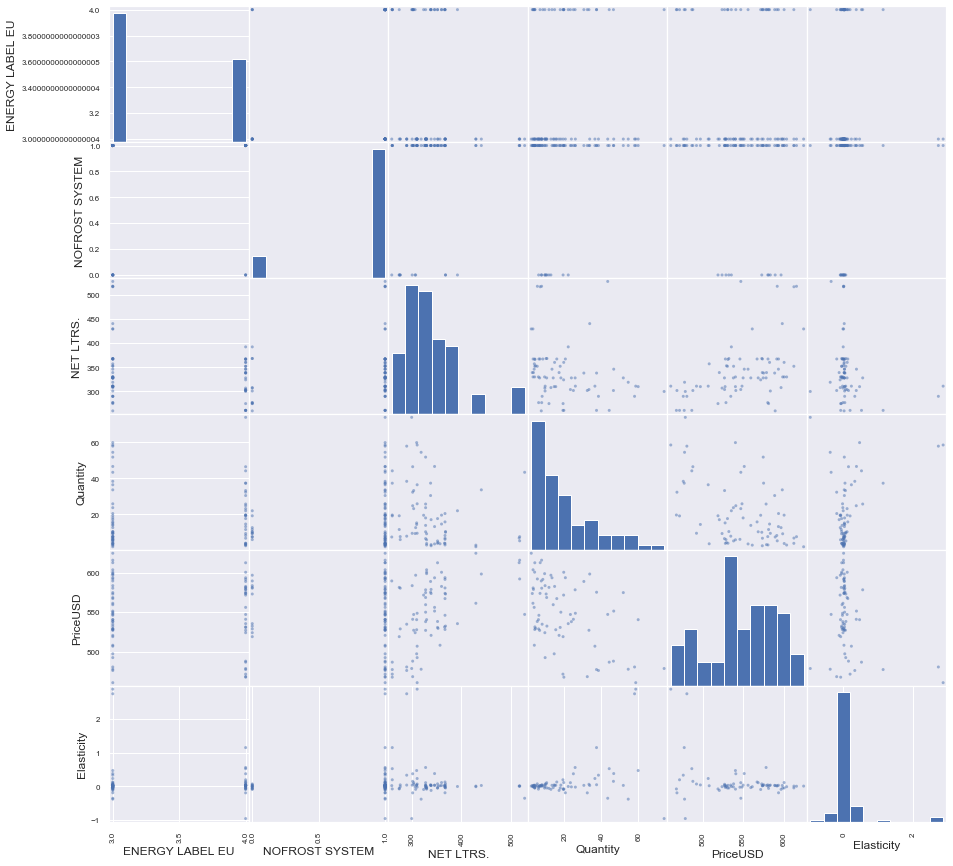

Кластер 8
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.   Quantity    PriceUSD  \
count        81.000000       81.000000   81.000000  81.000000   81.000000   
mean          3.197531        0.814815  309.654321  11.271192  438.319072   
std           0.485277        0.390868   36.993973   8.753759   32.974356   
min           2.000000        0.000000  224.000000   1.777778  341.340315   
25%           3.000000        1.000000  288.000000   4.545455  422.871989   
50%           3.000000        1.000000  308.000000   8.181818  444.017684   
75%           3.000000        1.000000  337.000000  16.545455  458.705174   
max           4.000000        1.000000  428.000000  41.083333  497.730882   

       Elasticity  
count   81.000000  
mean     0.015156  
std      0.123593  
min     -0.503089  
25%     -0.027333  
50%      0.008372  
75%      0.076920  
max      0.335390  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000       -0.3

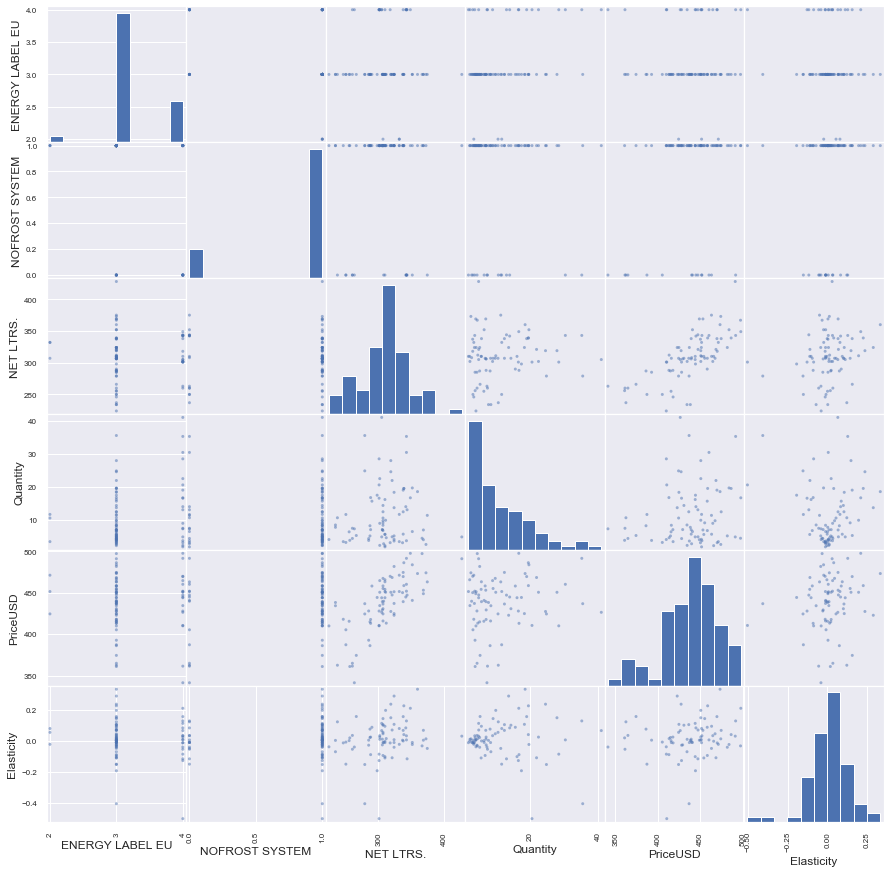

Кластер 9
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.    Quantity    PriceUSD  \
count        49.000000       49.000000   49.000000   49.000000   49.000000   
mean          2.918367        0.102041  320.122449   34.021772  327.081002   
std           0.640206        0.305839   26.175396   32.454625   27.328237   
min           1.000000        0.000000  265.000000    2.555556  290.269170   
25%           3.000000        0.000000  300.000000    9.277778  306.054811   
50%           3.000000        0.000000  324.000000   27.226742  319.898404   
75%           3.000000        0.000000  339.000000   50.588106  346.716178   
max           4.000000        1.000000  373.000000  193.333333  394.313494   

       Elasticity  
count   49.000000  
mean     0.052291  
std      0.643240  
min     -2.175183  
25%     -0.244180  
50%      0.027251  
75%      0.219309  
max      1.952064  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000  

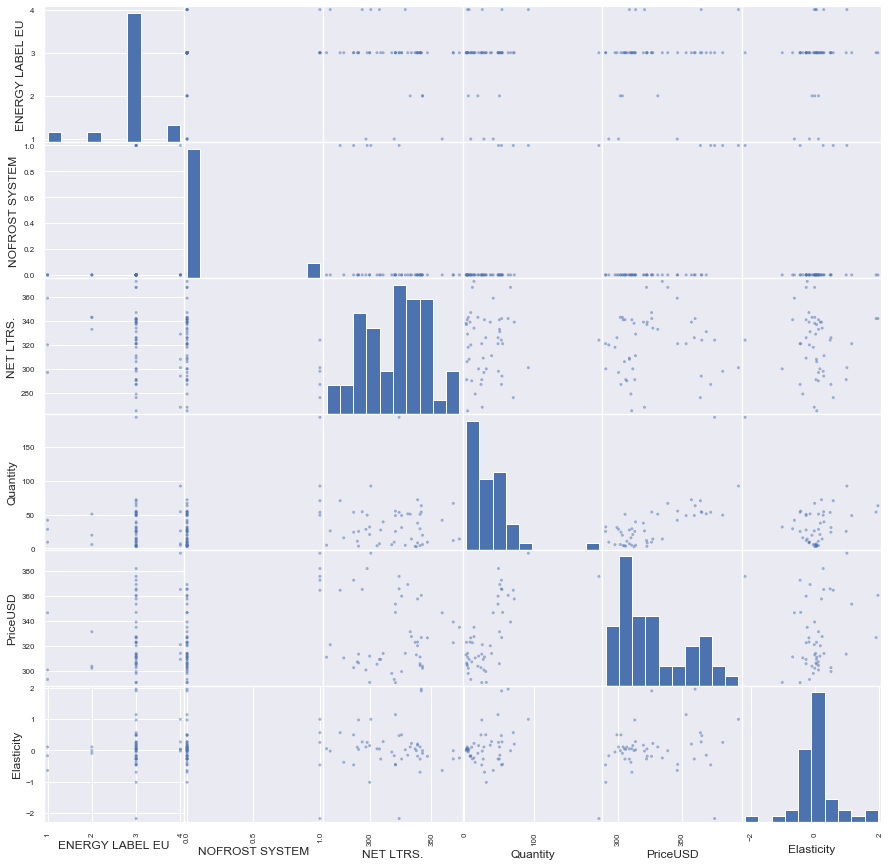

Кластер 10
       ENERGY LABEL EU  NOFROST SYSTEM   NET LTRS.   Quantity    PriceUSD  \
count        74.000000       74.000000   74.000000  74.000000   74.000000   
mean          3.013514        0.202703  324.324324  15.609219  369.367963   
std           0.421778        0.404757   27.284452  16.674052   32.822398   
min           1.000000        0.000000  279.000000   1.608333  318.007144   
25%           3.000000        0.000000  302.000000   5.694444  341.747848   
50%           3.000000        0.000000  321.000000   9.534217  361.303178   
75%           3.000000        0.000000  342.750000  17.932977  394.014593   
max           4.000000        1.000000  393.000000  82.243874  441.902643   

       Elasticity  
count   74.000000  
mean     0.041493  
std      0.234861  
min     -0.483023  
25%     -0.054850  
50%      0.005441  
75%      0.081303  
max      1.169534  
                 ENERGY LABEL EU  NOFROST SYSTEM  NET LTRS.  Quantity  \
ENERGY LABEL EU         1.000000        0.

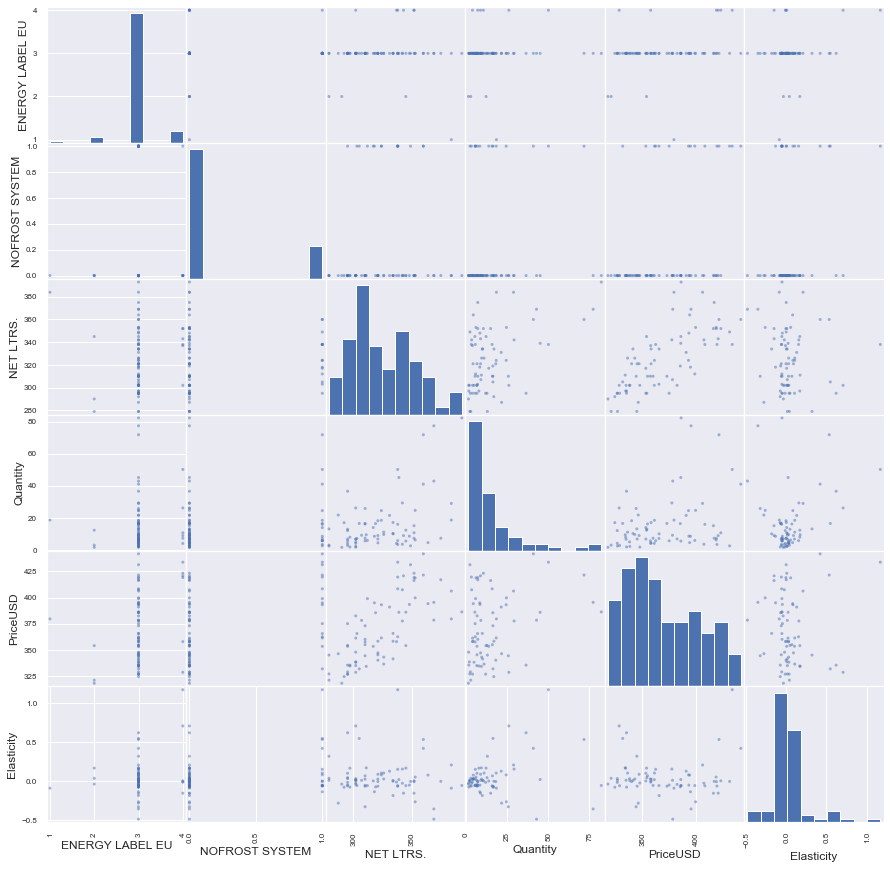

In [50]:
for i in np.unique(clusters):# виведемо відомості по класам
    print('Кластер ' + str(i))
    print(data[data['cluster_ier_t_sne']==i][['ENERGY LABEL EU', 'NOFROST SYSTEM', 'NET LTRS.', 'Quantity', 'PriceUSD', 'Elasticity']].describe())
    print(data[data['cluster_ier_t_sne']==i][['ENERGY LABEL EU', 'NOFROST SYSTEM', 'NET LTRS.', 'Quantity', 'PriceUSD', 'Elasticity']].corr())
    scatter_matrix(data[data['cluster_ier_t_sne']==i][['ENERGY LABEL EU', 'NOFROST SYSTEM', 'NET LTRS.', 'Quantity', 'PriceUSD', 'Elasticity']], cmap='flag', figsize=(15,15)) 
    plt.show()

In [51]:
data.to_csv('clust.csv')

In [52]:
data = data.reset_index(drop=True)

Cluster 1


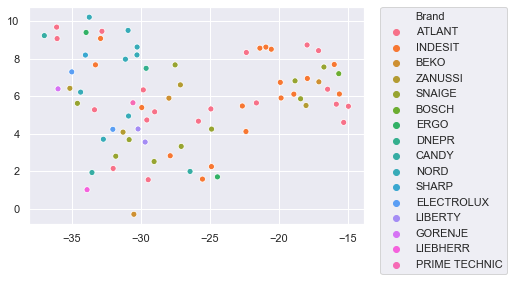

Cluster 2


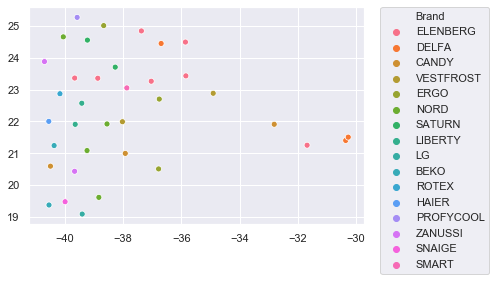

Cluster 3


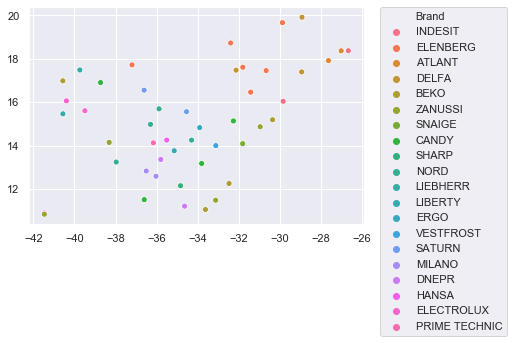

Cluster 4


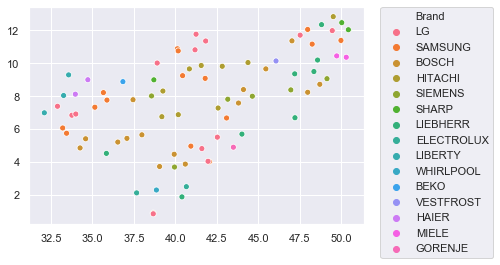

Cluster 5


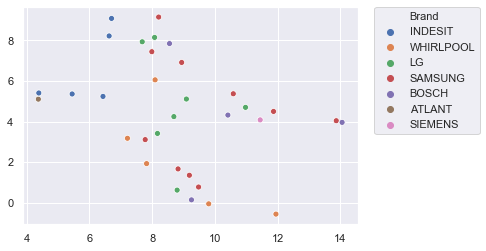

Cluster 6


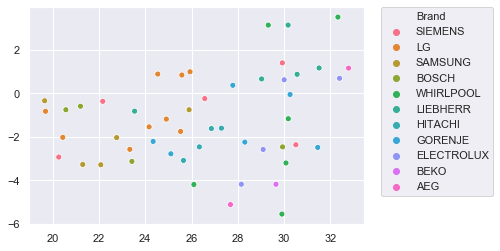

Cluster 7


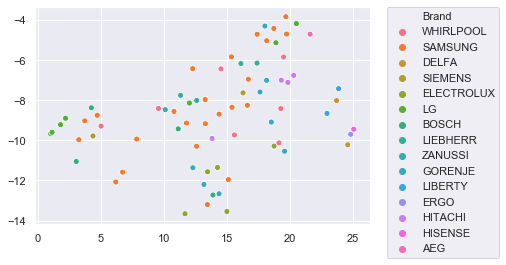

Cluster 8


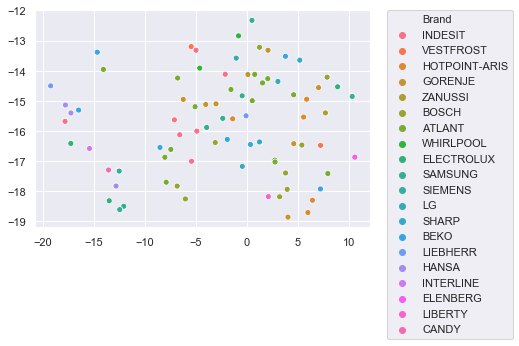

Cluster 9


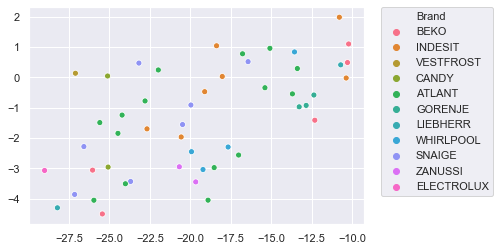

Cluster 10


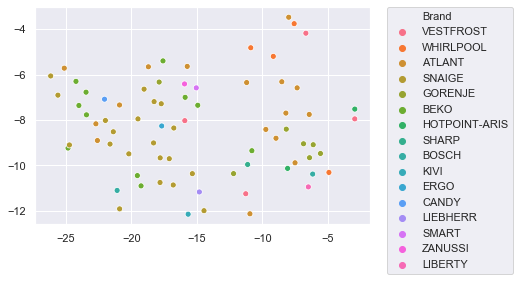

In [53]:
for i in range(1,11):# бренди-конкуренти по кластерам
    print('Cluster ' + str(i))
    index = data[data['cluster_ier_t_sne'] == i].index
    sns.scatterplot(digits_proj[index][:,0], digits_proj[index][:,1], hue=data[data['cluster_ier_t_sne'] == i]['Brand'], legend='full')# по брендам
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [54]:
def give_concurente_models(data, name_clust, model):# моделі-конкуренти
    c_num = data[data['Model'] == model][name_clust].unique()[0]
    return data[data[name_clust] == c_num]['Model'].unique()

In [55]:
print('Конкуренти для моделі RS57K4000SA/EF: ' + str(give_concurente_models(data, 'cluster_ier_t_sne', 'RS57K4000SA/EF')))

Конкуренти для моделі RS57K4000SA/EF: ['GN-H702HEHZ' 'RT46K6340S8/UA' 'KGN49XL30G' 'RT46K6340EF/UA'
 'RT53K6330SL/UA' 'GC-B247JMUV' 'RT53K6330EF/UA' 'GC-B247SEUV'
 'RS57K4000SA/EF' 'GN-H702HMHZ' 'RSA 1 RHMG1' 'KGN49XW30U' 'GN-H702HQHZ'
 'RS57K4000WW/UA' 'RT53K6340UT/WT' 'RB41J7851SR' 'RB37K63402C/UA'
 'RSA1SHVB1/BWT' 'RB37K63401L/UA' 'GC-B247SVUV' 'R-VG610PUC3 (GGR)'
 'KGN39LB35U' 'KG49NLW30' 'GC-Q247CABV' 'GA-B499TGBM' 'KGN49LB30U'
 'R-W660PUC3 GBK' 'RS62K6267FG/UA' 'SJ-EX820FBE / SJEX820FBE'
 'RF50K5960DP/UA' 'GC-M247CMBV' 'GR-H802HMHZ' 'GA-B499TGDF' 'CN 5715'
 'ENN93153AW' 'KGN49XI30U' 'R-VG660PUC3 (GGR)' 'KGN49XI30' 'KIN86AD30'
 'R-VG660PUC3GPW' 'KGN39LB35' 'ERN 93213 AW' 'HSBS-580 GB' 'KG49NAI31'
 'KG56NVI30U' 'ART 963/A+/NF' 'SBS 7212 COMFORT' 'ICUNS 3324' 'KGN49XL30U'
 'GN 163120' 'KI86NAD30' 'GA-B499TGRF' 'DSBS-540 X' 'SSBS-612 GS'
 'SJ-EX820FSL' 'KGN39AW35' 'KGN 86AI30U' 'KGN56VI30U' 'KGN56LB30N'
 'KG39FSW45' 'R-VG540PUC3GBK' 'FW 540 M' 'IK 3520' 'R-WB800PUC5XGR'
 'CBN 4815' '